In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os,sys, gc
import keras

dirpath = os.getcwd().split("code")[0]+"code/"
sys.path.append(dirpath)
from pre_process import clean_LC,generate_representation
from evaluation import calculate_metrics, evaluate_metadata, evaluate_metadata_raw


folder = "../../KOI_Data/"
folder_lc = "/work/work_teamEXOPLANET/KOI_LC/"

Using TensorFlow backend.


In [2]:
def impute_on_pandas(df):
    return df.fillna(df.median(),inplace=False)

df_meta = pd.read_csv(folder+"/kepler_dataset.csv")
all_labels = df_meta["NExScI Disposition"]
mask_conf = (all_labels=="CONFIRMED").values
mask_fp = (all_labels=="FALSE POSITIVE").values
mask_cand = (all_labels=="CANDIDATE").values

metadata_used = ["Period", "Duration", "Time of Transit Epoch", "r/R", "a/R",
                 "Inclination", "Limb Darkening Coeff1", "Limb Darkening Coeff2",
                 "Teq", "Fitted Stellar Density",
                "Teff","Stellar Radius", "Stellar Mass"]
#dividir duration por 24??
df_meta["Duration"] = df_meta["Duration"]/24

time_kepler = np.load(folder_lc+"npy/KOI_LC_time.npy")
#df_meta["Time of Transit Epoch"] = df_meta["Time of Transit Epoch"]- time_kepler[:,0] #modificacion

df_meta_obj = df_meta[metadata_used]
mask_nan = pd.isna(df_meta_obj)

df_meta_obj = impute_on_pandas(df_meta_obj)

df_meta_obj.head()

Period  Duration  Time of Transit Epoch    r/R      a/R  Inclination  \
0    8.884923  0.086252             169.991686  0.114   36.466        89.89   
1    5.092465  0.152458             357.535940  0.014   10.670        89.14   
2  275.073650  0.140417             315.248600  0.014  512.000        89.93   
3    8.460439  0.197288             133.774490  0.478   14.087        85.68   
4   21.761298  0.051792             166.540438  0.032  137.070        89.95   

   Limb Darkening Coeff1  Limb Darkening Coeff2    Teq  \
0                  0.497                  0.204  770.0   
1                  0.551                  0.165  844.0   
2                  0.437                  0.243  303.0   
3                  0.299                  0.306  804.0   
4                  0.627                  0.108  486.0   

   Fitted Stellar Density    Teff  Stellar Radius  Stellar Mass  
0                11.62061  5332.0           0.843         0.821  
1                 0.88510  5037.0           0.751         0.727  
2                33.55994  5604.0           1.187         0.864  
3                 0.73874  5951.0           0.702         0.796  
4               102.86534  4859.0           0.720         0.781

In [3]:
df_sets = pd.read_csv(folder+"/koi_sets.csv") 
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unlabeled = (df_sets["Set"] == "Unlabeled").values

mask_train_conf = mask_train & mask_conf
mask_test_conf = mask_test & mask_conf

In [4]:
Y_train = df_meta_obj.values[mask_train_conf]
Y_test = df_meta_obj.values[mask_test_conf]
Y_train.shape

(1610, 13)

In [5]:
#pre-process: scale metadata
from sklearn.preprocessing import StandardScaler, RobustScaler
#scaler_meta = RobustScaler()
scaler_meta = StandardScaler()

Ystd_train = scaler_meta.fit_transform(Y_train)
Ystd_test = scaler_meta.transform(Y_test)

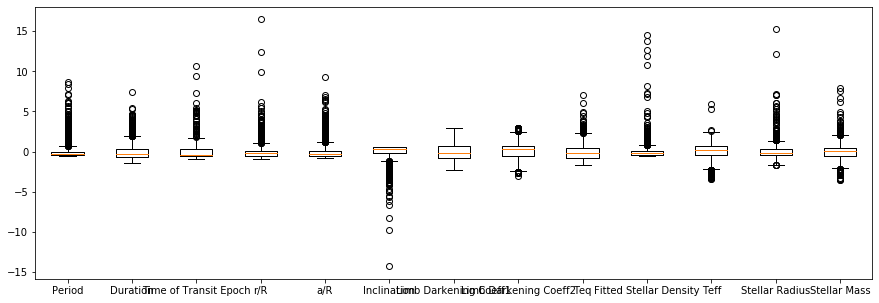

Period      Duration  Time of Transit Epoch           r/R  \
count  1.610000e+03  1.610000e+03           1.610000e+03  1.610000e+03   
mean  -3.054837e-17  7.499867e-16           5.907007e-15 -1.612582e-15   
std    1.000311e+00  1.000311e+00           1.000311e+00  1.000311e+00   
min   -5.908227e-01 -1.450501e+00          -8.906004e-01 -8.851677e-01   
25%   -4.821600e-01 -6.703882e-01          -5.516610e-01 -5.040630e-01   
50%   -3.365976e-01 -2.669818e-01          -4.050554e-01 -2.076482e-01   
75%   -1.750069e-03  3.716218e-01           3.663228e-01  1.311116e-01   
max    8.616681e+00  7.401561e+00           1.070401e+01  1.647627e+01   

                a/R   Inclination  Limb Darkening Coeff1  \
count  1.610000e+03  1.610000e+03           1.610000e+03   
mean   1.519764e-15 -6.772423e-14          -2.639779e-15   
std    1.000311e+00  1.000311e+00           1.000311e+00   
min   -8.407552e-01 -1.431460e+01          -2.258535e+00   
25%   -5.662212e-01 -1.426957e-01          -8.013483e-01   
50%   -3.274285e-01  3.226130e-01          -1.761280e-01   
75%    1.281076e-01  5.689991e-01           7.206023e-01   
max    9.296306e+00  6.317726e-01           2.932537e+00   

       Limb Darkening Coeff2           Teq  Fitted Stellar Density  \
count           1.610000e+03  1.610000e+03            1.610000e+03   
mean            2.343305e-14  2.427320e-17            6.172502e-16   
std             1.000311e+00  1.000311e+00            1.000311e+00   
min            -3.089904e+00 -1.728111e+00           -5.335584e-01   
25%            -5.591437e-01 -7.441942e-01           -4.219073e-01   
50%             2.596318e-01 -1.479202e-01           -2.298973e-01   
75%             7.062367e-01  4.921406e-01            8.804824e-02   
max             2.983921e+00  7.011231e+00            1.447999e+01   

               Teff  Stellar Radius  Stellar Mass  
count  1.610000e+03    1.610000e+03  1.610000e+03  
mean   2.711427e-16   -2.270130e-15  3.242375e-15  
std    1.000311e+00    1.000311e+00  1.000311e+00  
min   -3.395382e+00   -1.703084e+00 -3.525412e+00  
25%   -4.824721e-01   -4.884028e-01 -5.372881e-01  
50%    1.926621e-01   -1.801033e-01  9.894913e-03  
75%    6.795483e-01    2.726248e-01  5.044431e-01  
max    5.973887e+00    1.529320e+01  7.896348e+00

In [6]:
### boxplot de las variables..
plt.figure(figsize=(15,5))
plt.boxplot(Ystd_train)
plt.xticks(np.arange(len(metadata_used))+1,metadata_used)
plt.show()
aux_df = pd.DataFrame(Ystd_train)
aux_df.columns = metadata_used
aux_df.describe()

### Read light curves processed (detrended)

(8054, 71427)


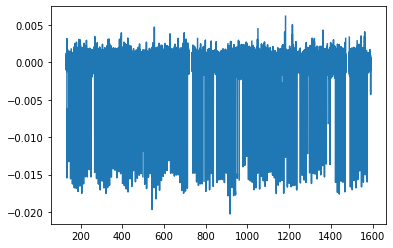

In [7]:
time_kepler = np.load(folder_lc+"npy/KOI_LC_time.npy")
#lc_kepler = np.load(folder_lc+"npy/KOI_LC_init.npy" )
process_lc = np.load(folder_lc+'/cleaned/LC_kepler_processed.npy')
N, T = time_kepler.shape
print((N,T))

plt.plot(time_kepler[0],process_lc[0])
plt.show()

In [8]:
time_kepler = time_kepler[mask_conf]
process_lc = process_lc[mask_conf]
N, T = time_kepler.shape
print((N,T))

(2281, 71427)


In [9]:
#borrar nans... arreglo variable
coupled_lc = []
coupled_time = []
delta_time = []
for i in range(N):
    mask_nan_aux = np.isnan(process_lc[i])
    coupled_lc.append(process_lc[i][~mask_nan_aux])
    
    time = time_kepler[i][~mask_nan_aux]
    # calculate delta time --> this could be done after padding is done..
    delta_time.append(np.hstack([[0],np.diff(time)]))
    coupled_time.append(time)
    
coupled_lc = np.asarray(coupled_lc)
coupled_time = np.asarray(coupled_time)
delta_time = np.asarray(delta_time)
coupled_time

array([array([ 131.5127147,  131.5331494,  131.553584 , ..., 1590.9606391,
       1590.9810737, 1591.0015084]),
       array([ 131.5126641,  131.5330988,  131.5535334, ..., 1590.9606018,
       1590.9810364, 1591.0014711]),
       array([ 131.5127088,  131.5331435,  131.5535781, ..., 1590.9606616,
       1590.9810961, 1591.0015309]),
       ...,
       array([ 131.5119906,  131.5324249,  131.5528591, ..., 1590.9605177,
       1590.9809518, 1591.001386 ]),
       array([ 131.5119561,  131.5323904,  131.5528246, ..., 1590.960477 ,
       1590.980911 , 1591.0013453]),
       array([ 131.5119643,  131.5323986,  131.5528328, ..., 1590.9604911,
       1590.9809252, 1591.0013595])], dtype=object)

#pre-process seleccionado

coupled_lc_scaled = []
for i in range(coupled_lc.shape[0]):
    std_i = coupled_lc[i].std(keepdims=True) #o std de todo
    
    coupled_lc_scaled.append( coupled_lc[i]/std_i )
coupled_lc_scaled = np.asarray(coupled_lc_scaled)
coupled_lc_scaled.shape

In [10]:
coupled_lc_scaled = coupled_lc

In [11]:
### data augm

flip_coupled_lc_scaled = []
flip_delta_time = []
flip_time = []
for i in range(coupled_lc.shape[0]):    
    flip_coupled_lc_scaled.append( coupled_lc_scaled[i][::-1] )
    flip_delta_time.append(  np.hstack([[0], delta_time[i][1:][::-1]]) )
    flip_time.append( coupled_time[i][0] + np.cumsum(flip_delta_time[-1]))
    
flip_coupled_lc_scaled = np.asarray(flip_coupled_lc_scaled)
flip_delta_time = np.asarray(flip_delta_time)
flip_time = np.asarray(flip_time)

delta_time = np.concatenate([delta_time, flip_delta_time])
coupled_lc_scaled = np.concatenate([coupled_lc_scaled, flip_coupled_lc_scaled])
coupled_time = np.concatenate([coupled_time, flip_time])

del flip_delta_time, flip_coupled_lc_scaled, flip_time
gc.collect()
coupled_lc_scaled.shape

(4562,)

### Folded

In [12]:
### from https://github.com/google-research/exoplanet-ml/blob/master/exoplanet-ml/light_curve/util.py

def phase_fold_time(time, period, t0):
  """Creates a phase-folded time vector.
  result[i] is the unique number in [-period / 2, period / 2)
  such that result[i] = time[i] - t0 + k_i * period, for some integer k_i.
  Args:
    time: 1D numpy array of time values.
    period: A positive real scalar; the period to fold over.
    t0: The center of the resulting folded vector; this value is mapped to 0.
  Returns:
    A 1D numpy array.
  """
  half_period = period / 2
  result = np.mod(time + (half_period - t0), period)
  result -= half_period
  return result

def phase_fold_and_sort_light_curve(time, values, period, t0):
  """Phase folds a light curve and sorts by ascending time.
  Args:
    time: 1D NumPy array of time values.
    values: N-dimensional NumPy array with the same length as time.
    period: A positive real scalar; the period to fold over.
    t0: The center of the resulting folded vector; this value is mapped to 0.
  Returns:
    folded_time: 1D NumPy array of phase folded time values in
        [-period / 2, period / 2), where 0 corresponds to t0 in the original
        time array. Values are sorted in ascending order.
    folded_values: NumPy array. Values are the same as the original values
        array, but sorted by folded_time.
  """
  # Phase fold time.
  time = phase_fold_time(time, period, t0)

  # Sort by ascending time.
  sorted_i = np.argsort(time)
  time = time[sorted_i]
  values = values[sorted_i]

  return time, values

def generate_view(time,
                  values,
                  num_bins,
                  bin_width,
                  t_min,
                  t_max,
                  normalize=True):
  """Generates a view of a phase-folded and binned light curve.
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    num_bins: The number of intervals to divide the time axis into.
    bin_width: The width of each bin on the time axis.
    t_min: The inclusive leftmost value to consider on the time axis.
    t_max: The exclusive rightmost value to consider on the time axis.
    normalize: Whether to center the median at 0 and minimum value at -1.
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  view, bin_counts = bin_and_aggregate(time, values, num_bins,
                                               bin_width, t_min, t_max)
  # Empty bins fall back to the global median.
  view = np.where(bin_counts > 0, view, np.median(values))
  return view

def global_view(time, values, period, num_bins=2001, bin_width_factor=1 / 2001):
  """Generates a 'global view' of a phase folded light curve.
  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of period.
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=period * bin_width_factor,
      t_min=-period / 2,
      t_max=period / 2)


def local_view(time,
               values,
               period,
               duration,
               num_bins=201,
               bin_width_factor=0.16,
               num_durations=4):
  """Generates a 'local view' of a phase folded light curve.
  See Section 3.3 of Shallue & Vanderburg, 2018, The Astronomical Journal.
  http://iopscience.iop.org/article/10.3847/1538-3881/aa9e09/meta
  Args:
    time: 1D NumPy array of time values, sorted in ascending order.
    values: N-dimensional NumPy array with the same length as time.
    period: The period of the event (in days).
    duration: The duration of the event (in days).
    num_bins: The number of intervals to divide the time axis into.
    bin_width_factor: Width of the bins, as a fraction of duration.
    num_durations: The number of durations to consider on either side of 0 (the
      event is assumed to be centered at 0).
  Returns:
    NumPy array of length num_bins containing the aggregated values in uniformly
    spaced bins on the phase-folded time axis.
  """
  return generate_view(
      time,
      values,
      num_bins=num_bins,
      bin_width=duration * bin_width_factor,
      t_min=max(-period / 2, -duration * num_durations),
      t_max=min(period / 2, duration * num_durations))

def bin_and_aggregate(x,
                      y,
                      num_bins,
                      bin_width=None,
                      x_min=None,
                      x_max=None,
                      aggr_fn=None):
  """Aggregates y-values in uniform intervals (bins) along the x-axis.
  The interval [x_min, x_max) is divided into num_bins uniformly spaced
  intervals of width bin_width. The value computed for each bin is the
  aggregation of all y-values whose corresponding x-value is in the interval.
  The default aggregation function is np.median.
  NOTE: x must be sorted in ascending order or the results will be incorrect.
  Args:
    x: 1D NumPy array of x-coordinates sorted in ascending order. Must have at
      least 2 elements, and all elements cannot be the same value.
    y: N-dimensional NumPy array with the same length as x.
    num_bins: The number of intervals to divide the x-axis into. Must be at
      least 2.
    bin_width: The width of each bin on the x-axis. Must be positive, and less
      than x_max - x_min. Defaults to (x_max - x_min) / num_bins.
    x_min: The inclusive leftmost value to consider on the x-axis. Must be less
      than or equal to the largest value of x. Defaults to min(x).
    x_max: The exclusive rightmost value to consider on the x-axis. Must be
      greater than x_min. Defaults to max(x).
    aggr_fn: A function that will be called with signature aggr_fn(y, axis=0) to
      aggregate values within each bin. Default is np.median.
  Returns:
    result: NumPy array of length num_bins containing the aggregated y-values of
      uniformly spaced bins on the x-axis.
    bin_counts: 1D NumPy array of length num_bins indicating the number of
      points in each bin.
  """
  if num_bins < 2:
    raise ValueError("num_bins must be at least 2. Got: {}".format(num_bins))

  # Validate the lengths of x and y.
  x_len = len(x)
  if x_len < 2:
    raise ValueError("len(x) must be at least 2. Got: {}".format(x_len))
  if x_len != len(y):
    raise ValueError("len(x) (got: {}) must equal len(y) (got: {})".format(
        x_len, len(y)))

  # Validate x_min and x_max.
  x_min = x_min if x_min is not None else x[0]
  x_max = x_max if x_max is not None else x[-1]
  if x_min >= x_max:
    raise ValueError("x_min (got: {}) must be less than x_max (got: {})".format(
        x_min, x_max))
  if x_min > x[-1]:
    raise ValueError(
        "x_min (got: {}) must be less than or equal to the largest value of x "
        "(got: {})".format(x_min, x[-1]))

  # Validate bin_width.
  bin_width = bin_width if bin_width is not None else (x_max - x_min) / num_bins
  if bin_width <= 0:
    raise ValueError("bin_width must be positive. Got: {}".format(bin_width))
  if bin_width >= x_max - x_min:
    raise ValueError(
        "bin_width (got: {}) must be less than x_max - x_min (got: {})".format(
            bin_width, x_max - x_min))

  bin_spacing = (x_max - x_min - bin_width) / (num_bins - 1)

  if aggr_fn is None:
    aggr_fn = np.median

  # Initialize output arrays.
  # Ensure default_value is a floating point type, otherwise the aggregated
  # values may unexpectedly be cast to a non-floating type.
  default_dtype = y.dtype if isinstance(y.dtype, np.floating) else np.float
  default_value = np.zeros_like(y[0], dtype=default_dtype)
  result = np.repeat([default_value], num_bins, axis=0)
  bin_counts = np.zeros(num_bins, dtype=np.int)

  # Find the first element of x >= x_min. This loop is guaranteed to produce
  # a valid index because we know that x_min <= x[-1].
  x_start = 0
  while x[x_start] < x_min:
    x_start += 1

  # The bin at index i is the aggregation of all elements y[j] such that
  # bin_min <= x[j] < bin_max, where bin_min and bin_max are the endpoints of
  # bin i.
  bin_min = x_min  # Left endpoint of the current bin.
  bin_max = x_min + bin_width  # Right endpoint of the current bin.
  j_start = x_start  # Inclusive left index of the current bin.
  j_end = x_start  # Exclusive end index of the current bin.

  for i in range(num_bins):
    # Move j_start to the first index of x >= bin_min.
    while j_start < x_len and x[j_start] < bin_min:
      j_start += 1

    # Move j_end to the first index of x >= bin_max (exclusive end index).
    while j_end < x_len and x[j_end] < bin_max:
      j_end += 1

    if j_end > j_start:
      # Compute and insert the aggregate y value in the bin.
      result[i] = aggr_fn(y[j_start:j_end], axis=0)
      bin_counts[i] = j_end - j_start

    # Advance the bin.
    bin_min += bin_spacing
    bin_max += bin_spacing

  return result, bin_counts

In [13]:
def folded_exampl(n):
    per, t0, dur = df_meta_obj[["Period", "Time of Transit Epoch","Duration"]].values[mask_conf][n]
    
    t = coupled_time[n][:]
    y = coupled_lc_scaled[n][:]

    #mask_nan = np.isnan(y)
    #t = t[~mask_nan]
    #y = y[~mask_nan]

    plt.plot(t, y, '.-')
    plt.show()

    t_fold, val_fold = phase_fold_and_sort_light_curve(t, y, period= per, t0= t0)

    plt.figure(figsize=(10,5))
    plt.plot(t_fold, val_fold, '.-')
    plt.title("folded")
    plt.show()

    plt.plot(t_fold)
    plt.show()
    
    t_glo = global_view(t_fold, val_fold, period=per, num_bins=1000, bin_width_factor=1 / 1000)
    
    plt.figure(figsize=(10,5))
    plt.plot(t_glo, '.-')
    plt.title("global view")
    plt.show()
    
    t_loc = local_view(t_fold, val_fold, period = per, duration=dur, num_bins=201, 
                       bin_width_factor=0.16,  num_durations=4)
    
    plt.figure(figsize=(10,5))
    plt.plot(t_loc, '.-')
    plt.title("local view")
    plt.show()

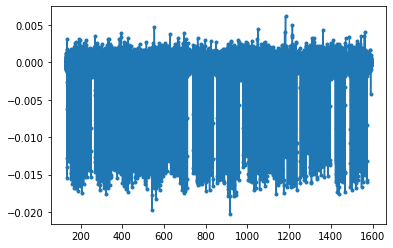

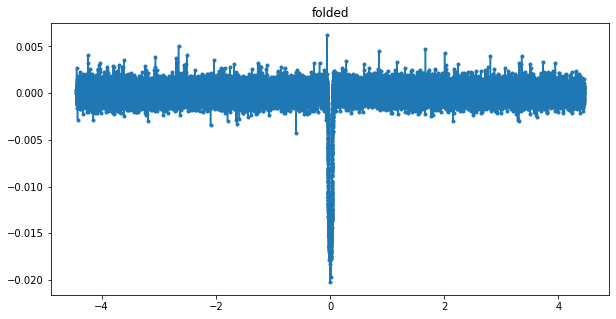

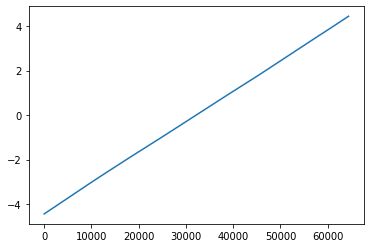

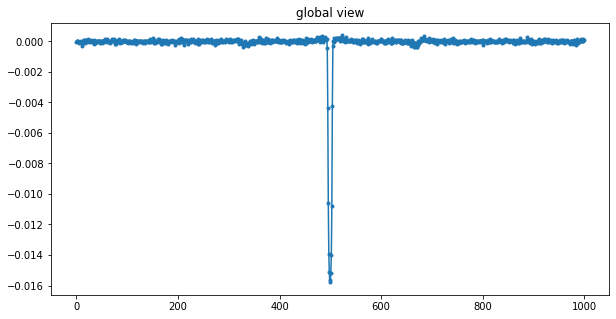

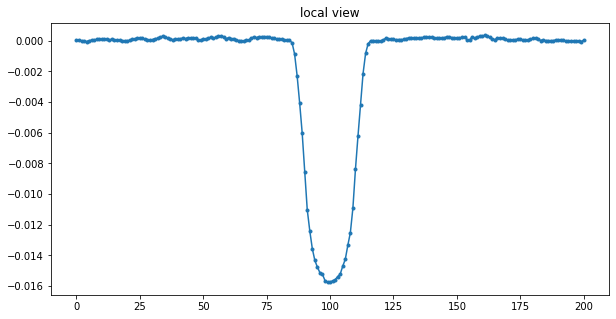

In [14]:
folded_exampl(0)

In [18]:
per, t0, dur = df_meta_obj[["Period", "Time of Transit Epoch","Duration"]].values[mask_conf][0]
    
t = coupled_time[0]
y = coupled_lc_scaled[0]

t_fold, val_fold = phase_fold_and_sort_light_curve(t, y, period= per, t0= t0)

In [19]:
t_fold

array([-4.44240434, -4.44209357, -4.44204916, ...,  4.44187633,
        4.44198238,  4.44236004])

In [20]:
val_fold

array([5.42180023e-06, 3.48759189e-04, 3.12933460e-04, ...,
       1.45365619e-03, 1.02920933e-03, 6.26585474e-06])

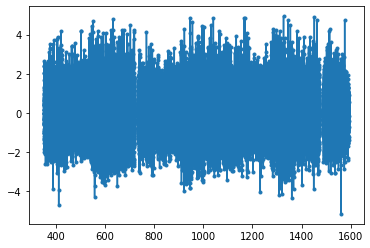

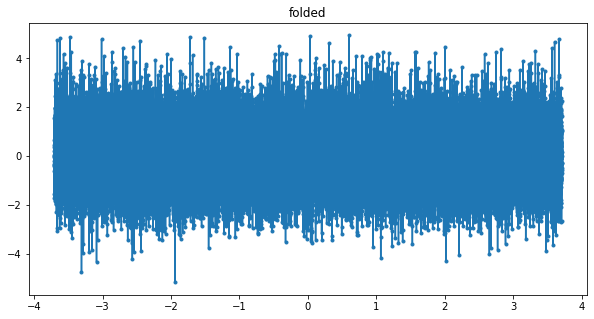

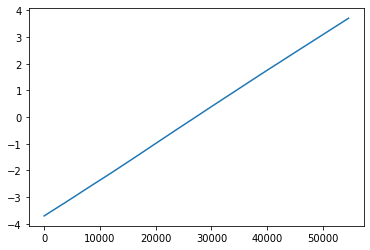

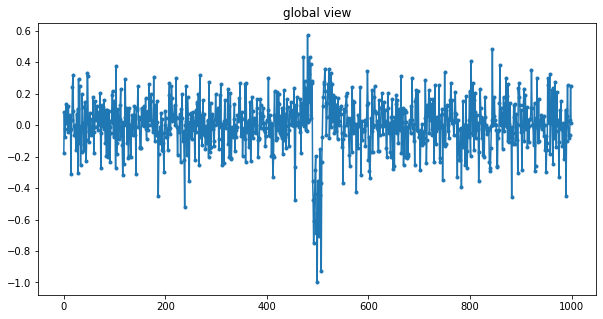

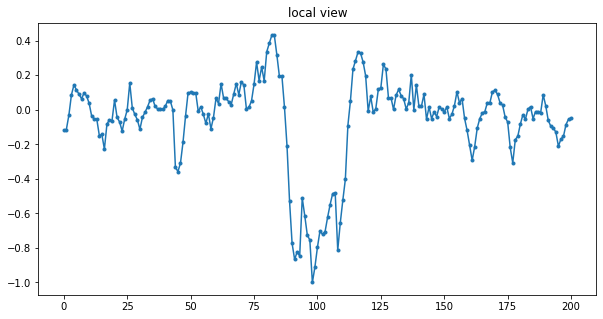

In [60]:
folded_exampl(5)

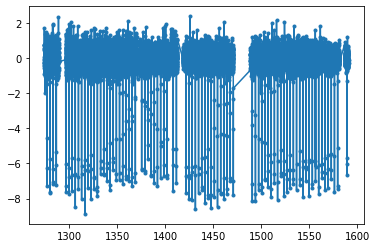

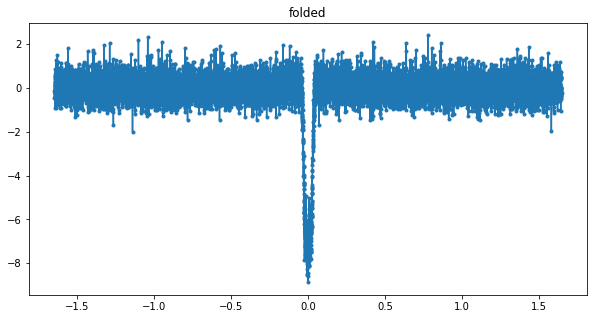

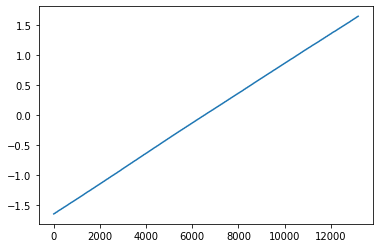

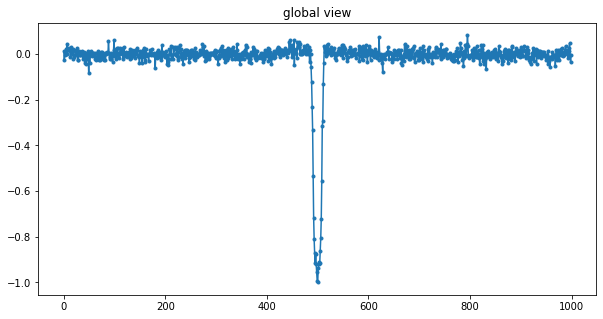

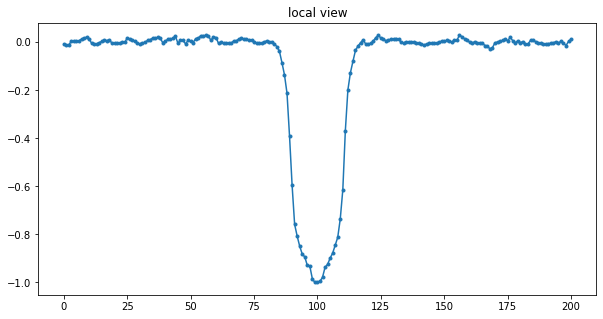

In [61]:
folded_exampl(9)

### Create dataset

In [ ]:
## intentar que sea en phase y no en global.. (muy smooth)

In [14]:
def std_scaler(x):
    mu = np.nanmean(x, axis=-1, keepdims=True)
    std = np.nanstd(x, axis=-1, keepdims=True)+1e-9
    return (x- mu)/std

In [15]:
T = 200 # CANTIDAD DE PUNTOS EN LA CURVA GLOBAL

X_fold_lc = []
X_fold_lc_aug = [] #con curvas invertidas
X_fold_time = []
for n in range(N):
    if n%500 == 0:
        print("Va en el, ",n)
        
    per, t0, dur = df_meta_obj[["Period", "Time of Transit Epoch","Duration"]].values[mask_conf][n]
    t = coupled_time[n]
    y = coupled_lc_scaled[n]

    t_fold, val_fold = phase_fold_and_sort_light_curve(t, y, period= per, t0= t0)

    val_glo = global_view(t_fold, val_fold, period=per, num_bins=T, bin_width_factor=1 / T)
    #preprocess global..
    val_glo = std_scaler(val_glo)
    
    X_fold_lc.append(val_glo)
    
    #dos opciones para revertir
    t_fold_aug = t_fold#*-1
    val_fold_aug = val_fold[::-1]
    
    val_glo = global_view(t_fold_aug, val_fold_aug, period=per, num_bins=T, bin_width_factor=1 / T)
    #preprocess global..
    val_glo = std_scaler(val_glo)
    
    X_fold_lc_aug.append(val_glo)
    
    #t_glo = np.linspace(0, per, T)
    t_glo_diff = np.concatenate([[0], np.tile(per/T, T-1)])  #np.diff(t_glo)
    X_fold_time.append(t_glo_diff) #differences values
    
X_fold_lc = np.asarray(X_fold_lc)
X_fold_lc_aug = np.asarray(X_fold_lc_aug)
X_fold_time = np.asarray(X_fold_time)
X_fold_lc.shape

Va en el,  0
Va en el,  500
Va en el,  1000
Va en el,  1500
Va en el,  2000


(2281, 200)

In [16]:
X_train = np.concatenate([X_fold_lc[mask_train[mask_conf]], X_fold_lc_aug[mask_train[mask_conf]]], axis=0)
X_train_t = np.concatenate([X_fold_time[mask_train[mask_conf]], X_fold_time[mask_train[mask_conf]]], axis=0)

if Ystd_train.shape[0] != X_train.shape[0]:
    Ystd_train = np.tile(Ystd_train, (2,1))

X_test = X_fold_lc[mask_test[mask_conf]]
X_test_t = X_fold_time[mask_test[mask_conf]]

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

X_train_t = np.expand_dims(X_train_t, axis=-1)
X_test_t = np.expand_dims(X_test_t, axis=-1)

print("X train shape: ",X_train.shape)
print("X train time shape: ",X_train_t.shape)
print("X test shape: ",X_test.shape)
print("Y train shape: ",Ystd_train.shape)
print("Y test shape: ",Ystd_test.shape)

X train shape:  (3220, 200, 1)
X train time shape:  (3220, 200, 1)
X test shape:  (671, 200, 1)
Y train shape:  (3220, 13)
Y test shape:  (671, 13)


### Keras models

In [17]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import *

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import matplotlib.pyplot as plt
def plot_n_lc(real_lc, decoded_lc, n = 10):
    for _ in range(n):
        n_sampled = np.random.randint(0, real_lc.shape[0])
        
        f, (ax1, ax2) = plt.subplots(1, 2, sharex=True,figsize= (15,5))
        ax1.plot(real_lc[n_sampled], 'b.-')
        ax1.set_title("Real")
        ax2.plot(decoded_lc[n_sampled], 'b.-')
        ax2.set_title("Reconstructed")
        plt.show()  

        plt.figure(figsize=(15,5))
        plt.plot(real_lc[n_sampled], 'bo-', label="Real")
        plt.plot(decoded_lc[n_sampled], 'g*-', label="Reconstructed")
        plt.title("Over")
        plt.legend()
        plt.show()
        print("----------------------------------------------------------------")

In [18]:
latent_dim = 32
T, channels = X_train.shape[1:]
D_dim = 5 #o variar: Period", "Duration", "Time of Transit Epoch", "r/R", "a/R",

## Regular VAE

In [19]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.)
    return z_mean + K.exp(0.5*z_log_var) * epsilon

def KL_loss(y_true, y_pred):
    return - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)

#### IF THIS IS USED,, KL WEIGHT NEEDED TO BE LOW ######
def MSE_loss(y_true, y_pred):
    v = K.mean( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

#### HAS TO BE USED IN ORDER TO LEARN #######
def SSE_loss(y_true, y_pred):
    v = K.sum( K.square( y_true - y_pred ), axis=1) #on time axis..    
    return K.flatten(v)

def vae_loss(y_true, y_pred):
    l = 0.01 #0.01 #kl weight
    return SSE_loss(y_true, y_pred) + l*KL_loss(y_true, y_pred)

In [20]:
x = Input(shape = (T, channels) )

f1 = GRU(64, return_sequences=True)(x) #bidirectional
f1 = GRU(64, return_sequences=False)(f1) #bidirectional

#f1 = Dense(128, activation='relu')(f1) #sacar?

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model(x, z_mean, name="encoder")



z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model(x, z, name="encoder_sampling")
samp_encoder.summary()





Model: "encoder_sampling"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 1)       0                                            
__________________________________________________________________________________________________
gru_1 (GRU)                     (None, 200, 64)      12672       input_1[0][0]                    
__________________________________________________________________________________________________
gru_2 (GRU)                     (None, 64)           24768       gru_1[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 32)           2080        gru_2[0][0]                      
_______________________________________________________________________________

In [21]:
decoder_input = Input(shape=(latent_dim,))
#decoder_hid = Dense(128, activation='relu') #pasara encode

decode = RepeatVector(T)(decoder_input)

decode = GRU(64, return_sequences=True)(decode) #bidirectional
decode = GRU(64, return_sequences=True)(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model(decoder_input, decode, name="generator")
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 200, 64)           0         
_________________________________________________________________
gru_3 (GRU)                  (None, 200, 64)           24768     
_________________________________________________________________
gru_4 (GRU)                  (None, 200, 64)           24768     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 200, 1)            65        
Total params: 49,601
Trainable params: 49,601
Non-trainable params: 0
_________________________________________________________________


In [22]:
# instantiate VAE model
out = generator(samp_encoder(x))
vae = Model(x, out)

vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

NameError: name 'recon_loss' is not defined

In [23]:
x = Input(shape = (T, channels) )

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model(x, z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model(x, z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model(decoder_input, decode, name="generator")

# instantiate VAE model
out = generator(samp_encoder(x))
vae = Model(x, out)
vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

batch_size = 64
vae.fit(X_train, X_train, epochs=20, batch_size=batch_size, validation_data=(X_test, X_test))

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 200, 1)            0         
_________________________________________________________________
encoder_sampling (Model)     (None, 15)                103326    
_________________________________________________________________
generator (Model)            (None, 200, 1)            104961    
Total params: 208,287
Trainable params: 208,287
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 3220 samples, validate on 671 samples
Epoch 1/20
3220/3220 [==============================] - 151s 47ms/step - loss: 15.0701 - KL_loss: 0.2413 - recon_loss: 14.8287 - val_loss: 14.3481 - val_KL_loss: 0.0980 - val_recon_loss: 14.2501
Epoch 2/20
3220/3220 [========================

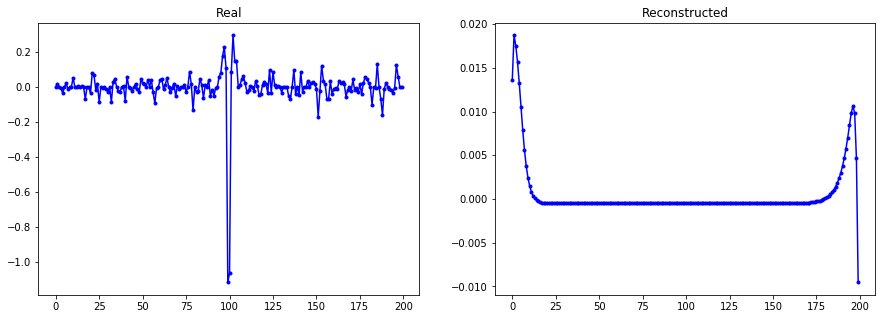

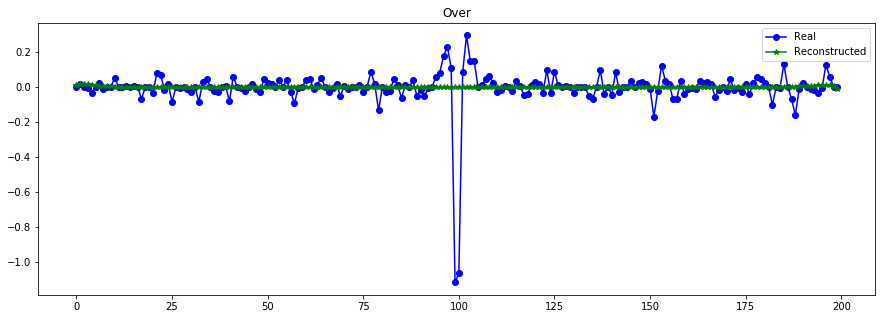

----------------------------------------------------------------


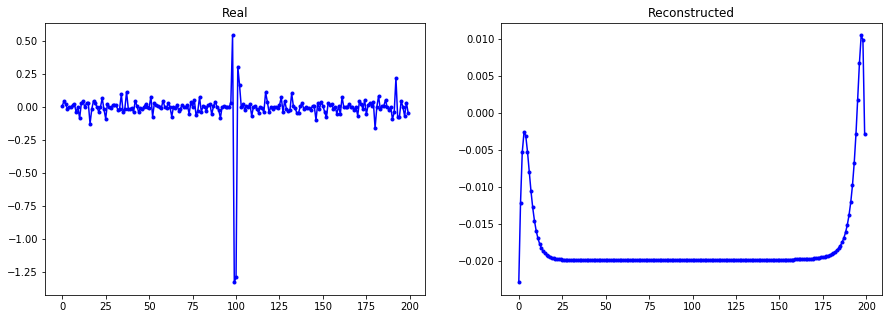

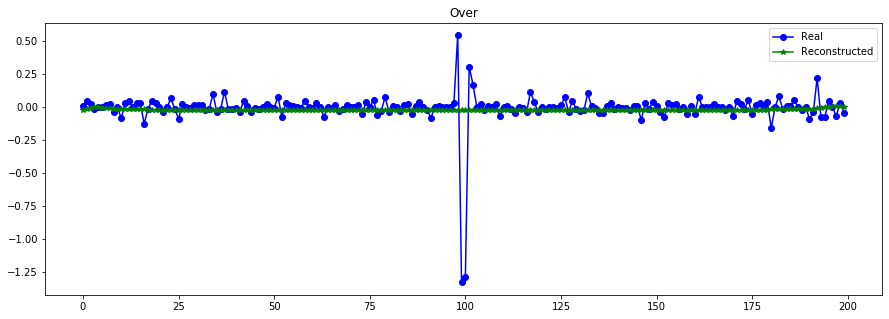

----------------------------------------------------------------


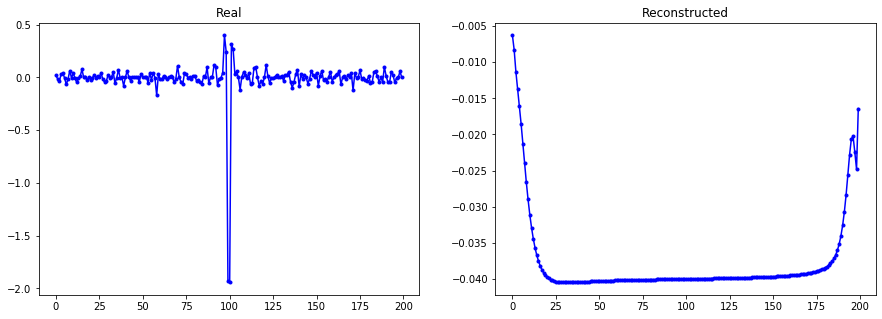

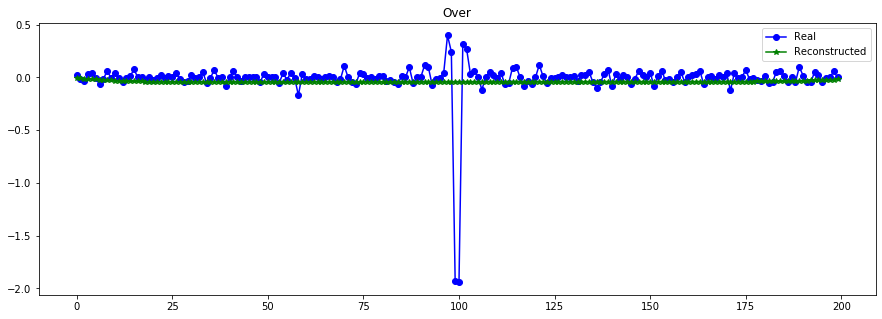

----------------------------------------------------------------


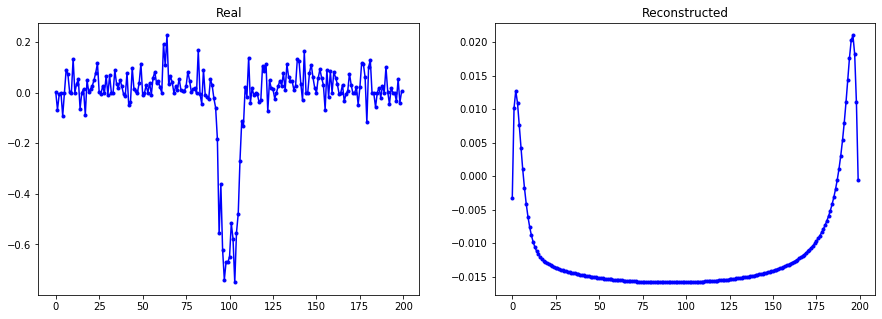

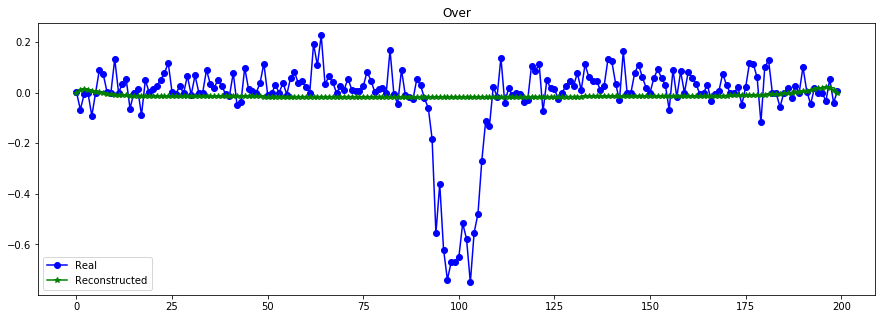

----------------------------------------------------------------


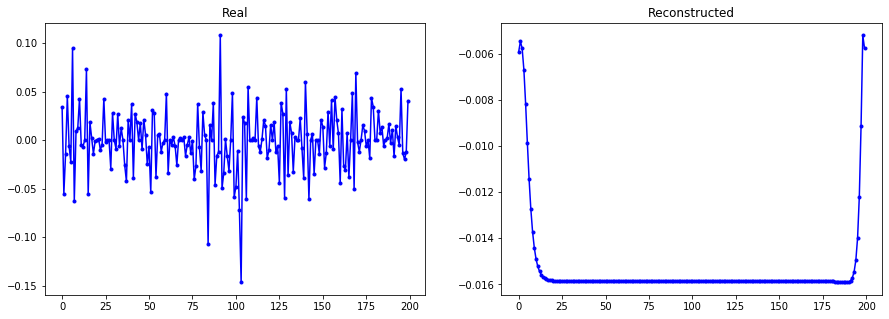

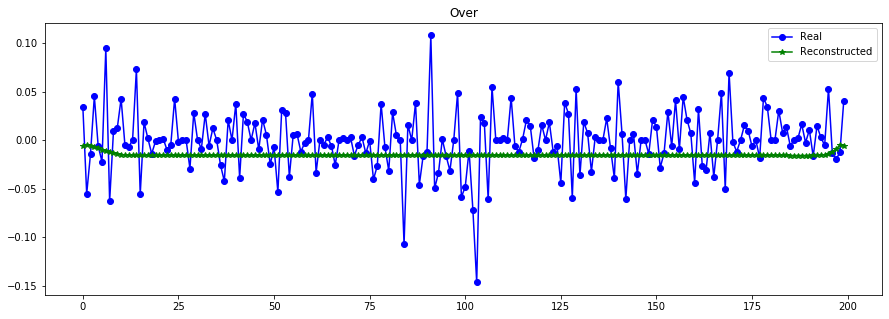

----------------------------------------------------------------


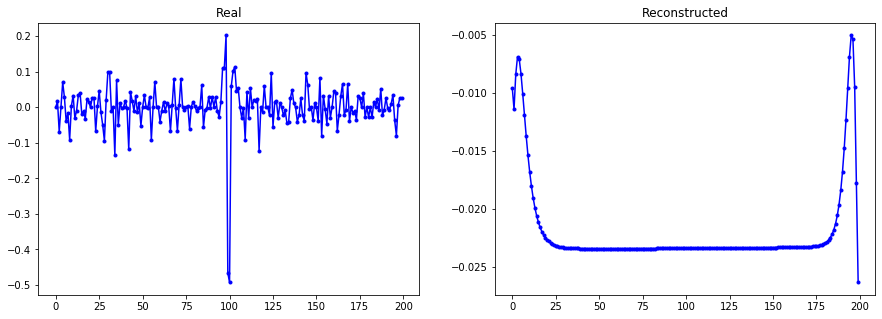

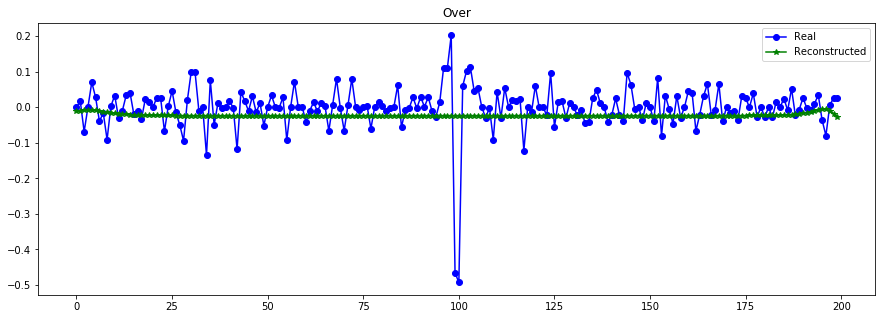

----------------------------------------------------------------


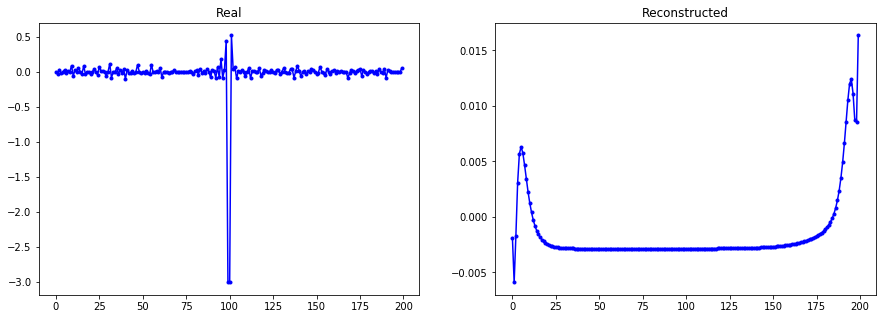

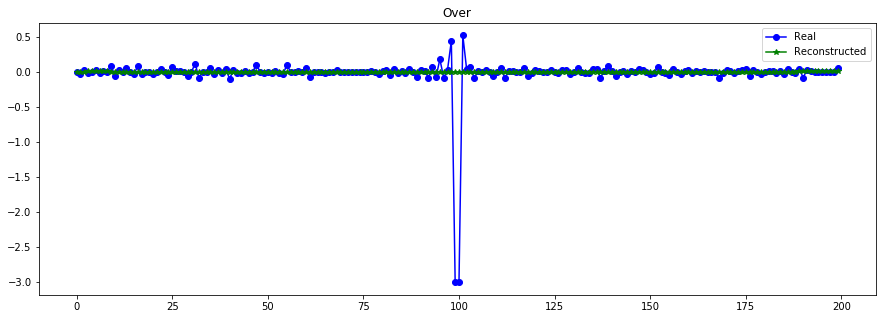

----------------------------------------------------------------


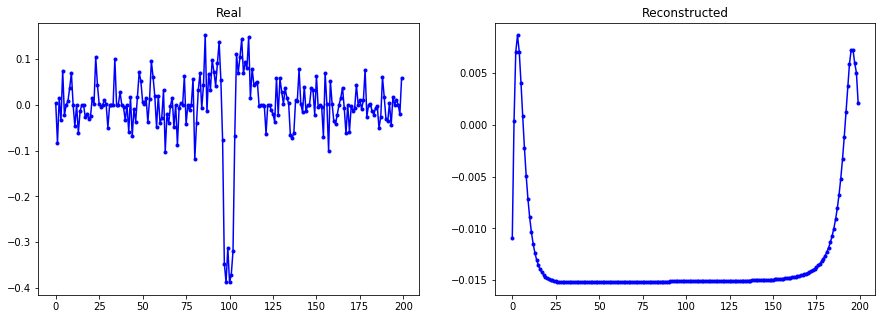

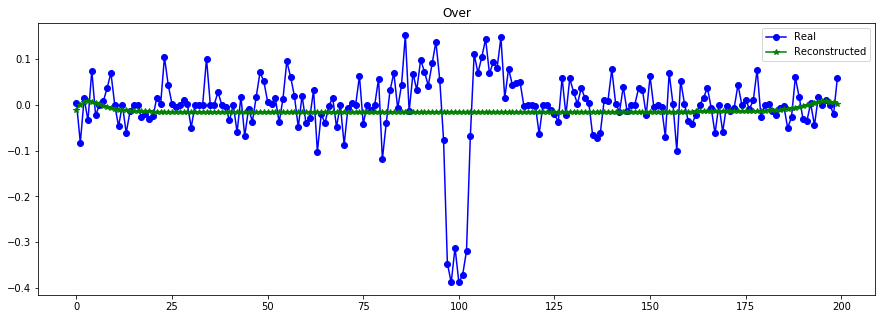

----------------------------------------------------------------


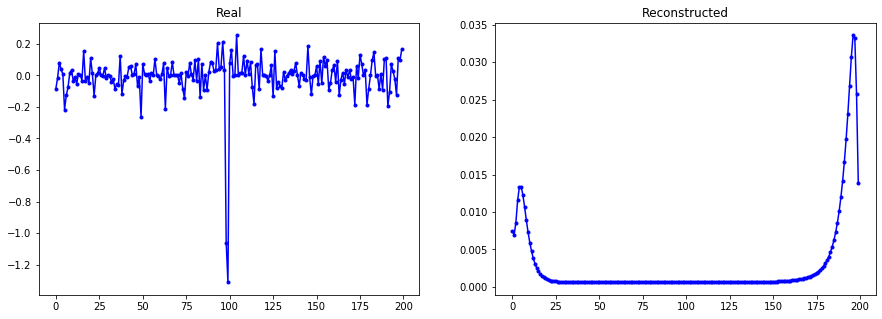

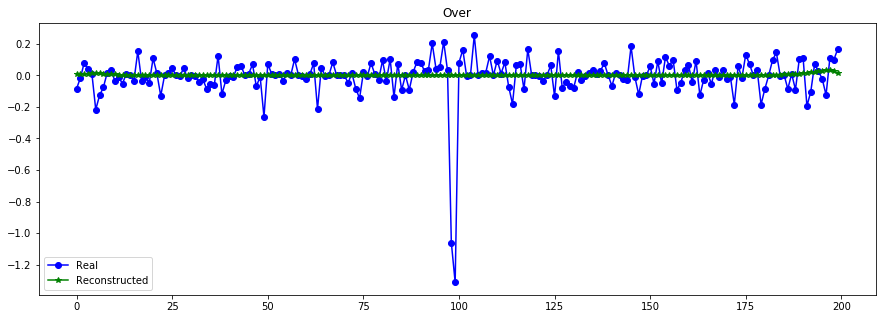

----------------------------------------------------------------


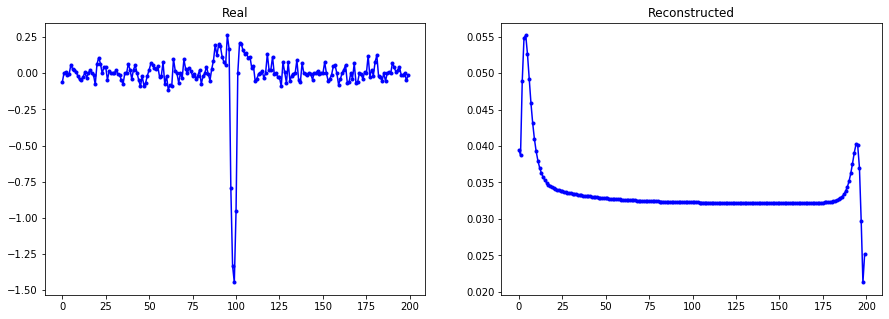

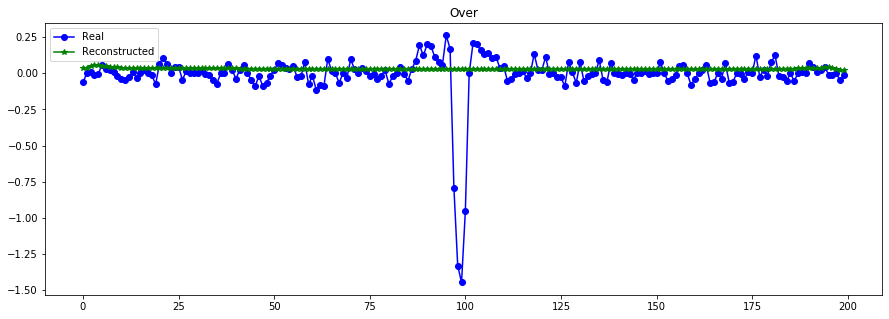

----------------------------------------------------------------


In [24]:
X_train_hat = vae.predict(X_train, batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

### Con tiempo, asimilando la arquitectura de Naul

In [27]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)

encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")


decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, MSE_loss])
vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 64)           116352      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       124161      T_inp[0][0]           

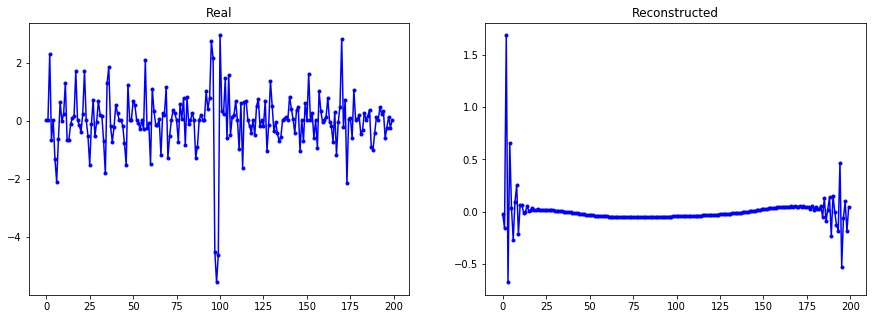

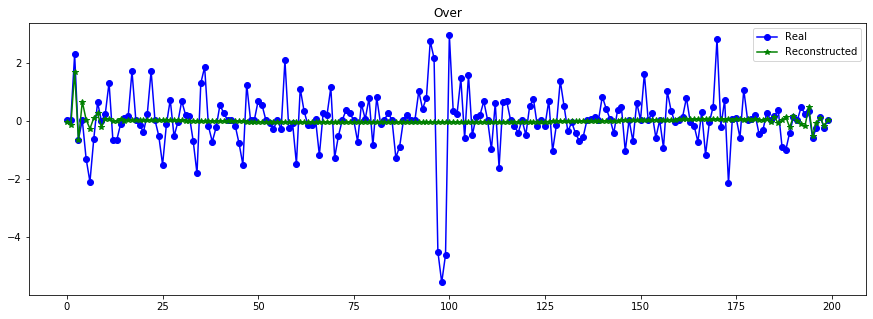

----------------------------------------------------------------


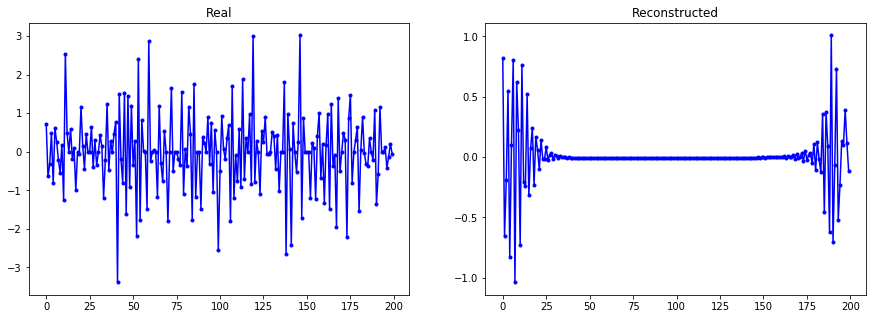

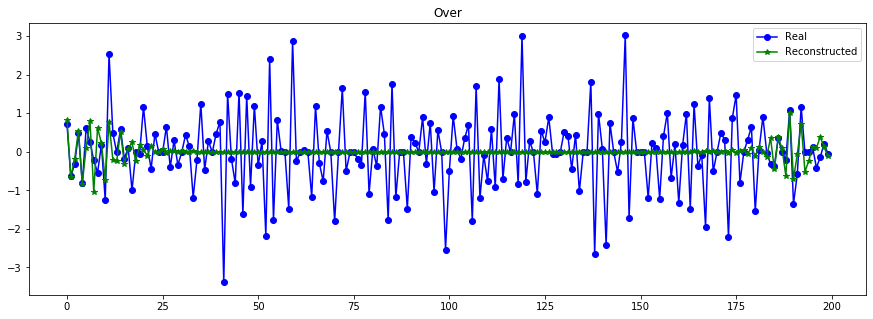

----------------------------------------------------------------


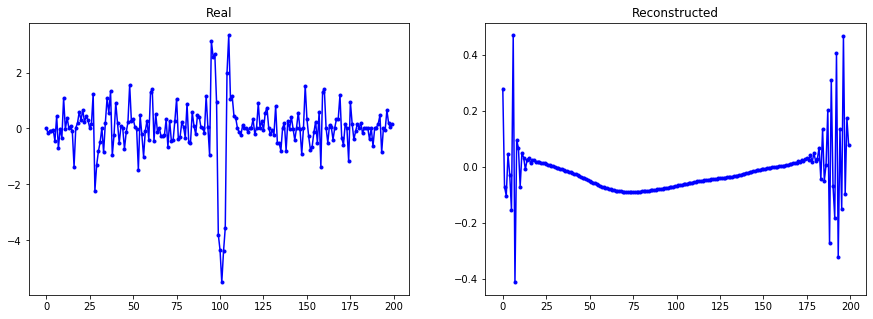

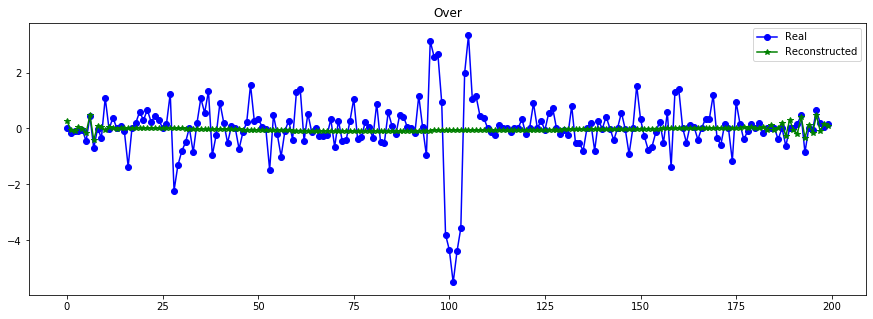

----------------------------------------------------------------


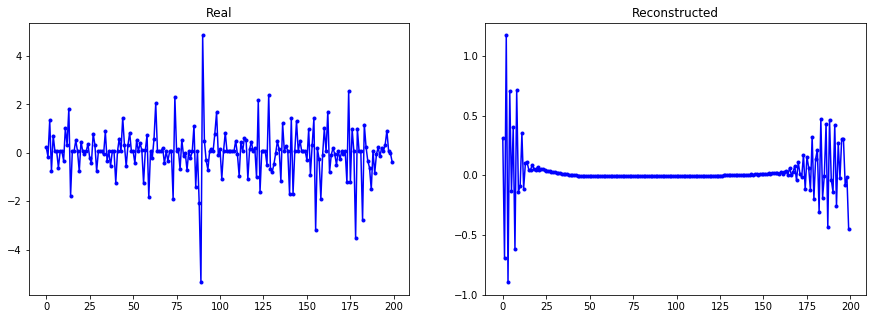

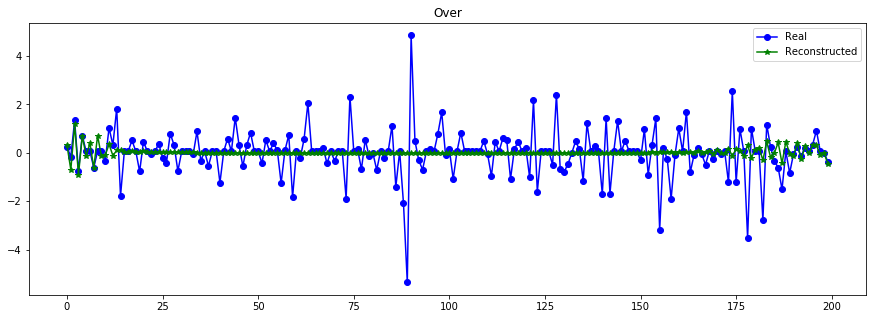

----------------------------------------------------------------


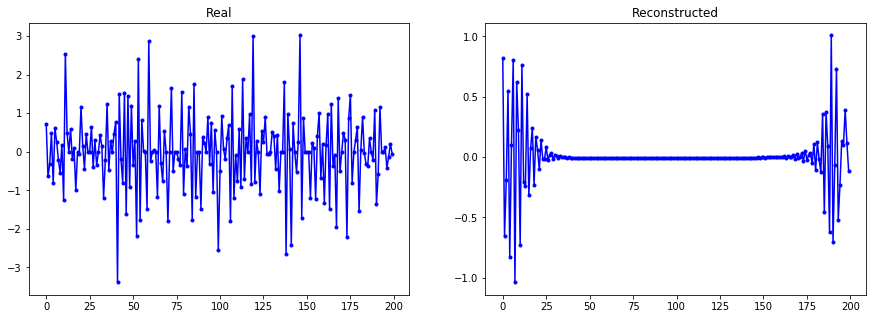

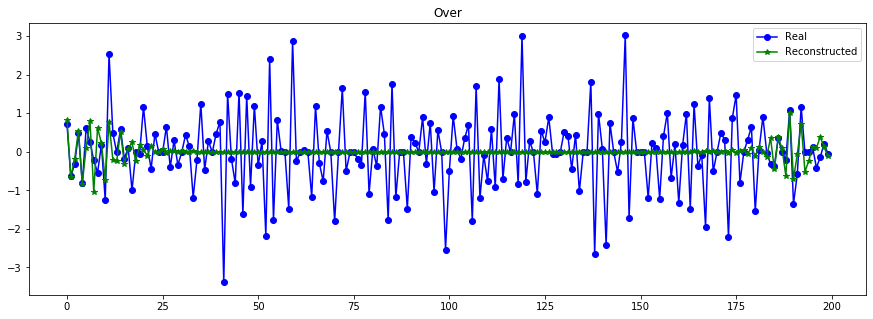

----------------------------------------------------------------


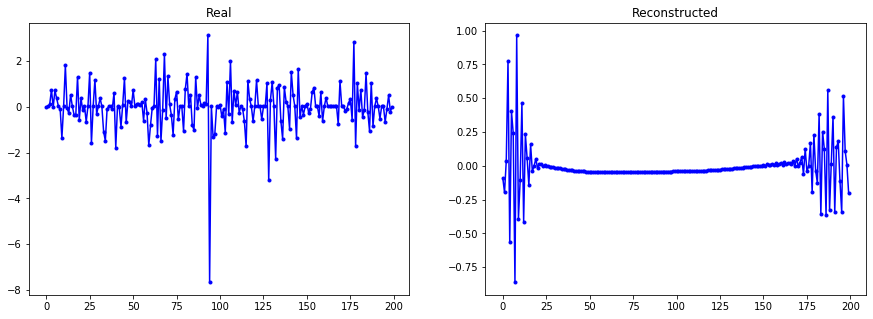

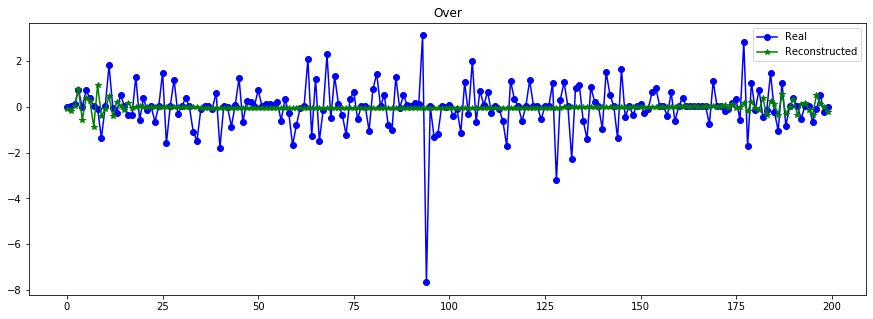

----------------------------------------------------------------


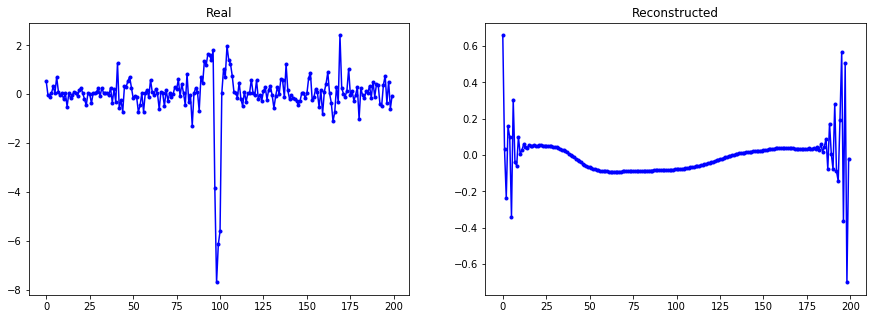

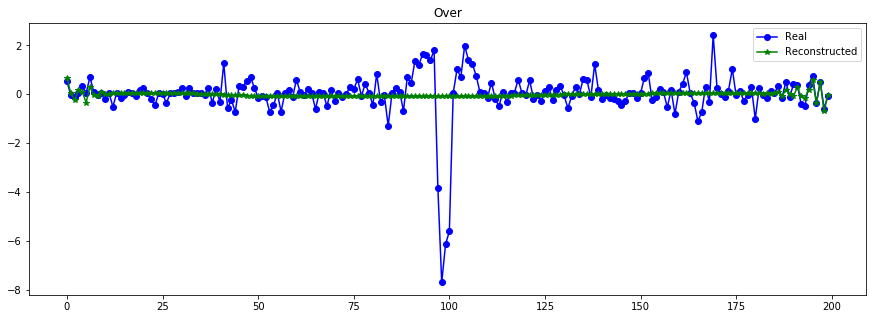

----------------------------------------------------------------


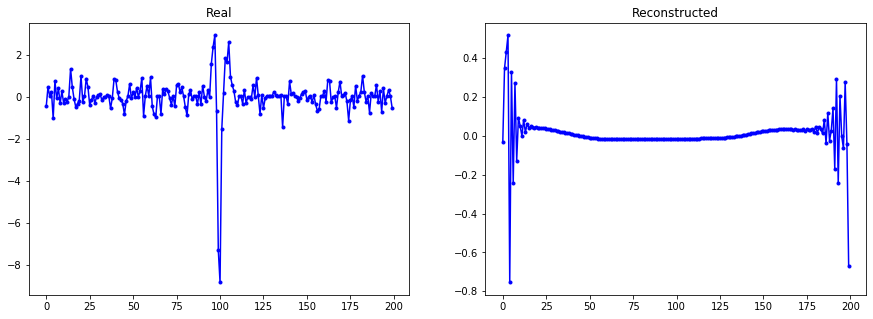

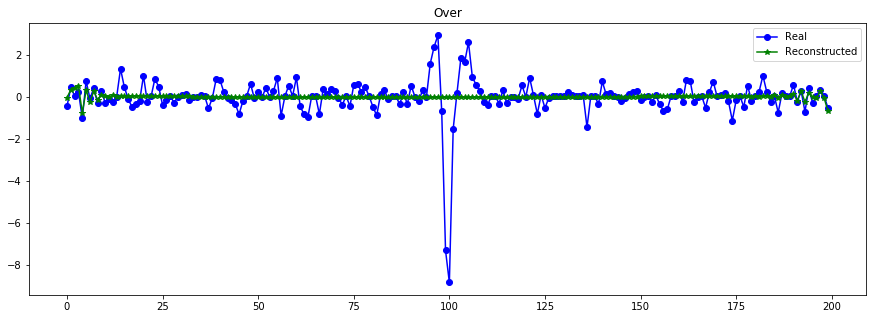

----------------------------------------------------------------


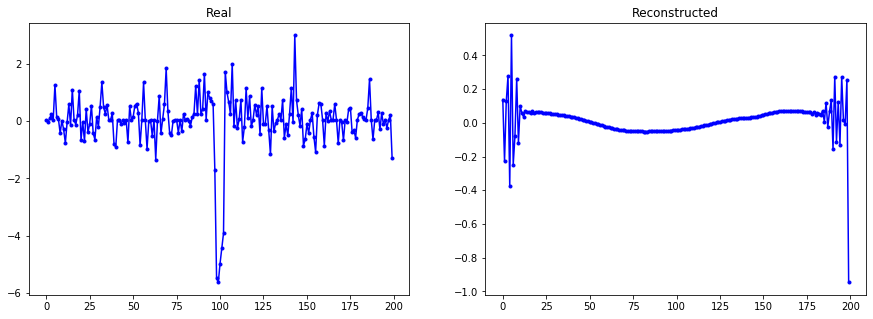

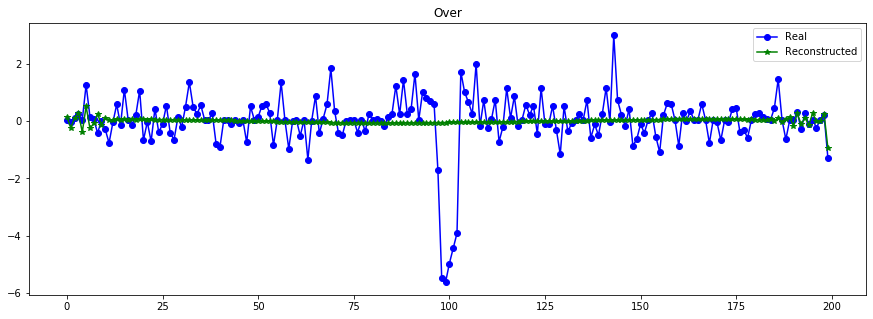

----------------------------------------------------------------


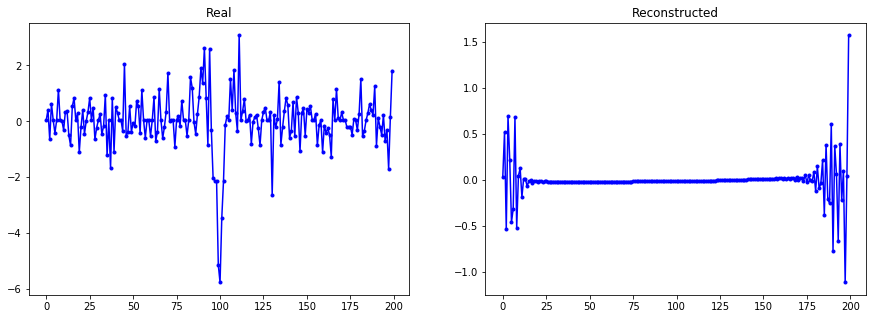

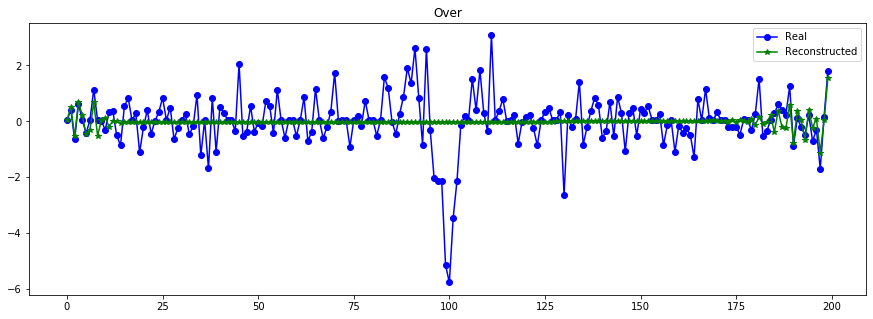

----------------------------------------------------------------


In [28]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

SI SIGUE MAL:
* BAJAR PESO A KL (0.1)
* AGREGAR DENSE ANTES DE REPEAT


In [21]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)

encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")


decoder_input = Input(shape=(latent_dim,))

decode = Dense(latent_dim, activation='relu')(decoder_input)


decode = RepeatVector(T)(decode)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_loss, metrics = [KL_loss, MSE_loss])
vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))






Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 32)           108096      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       112929      T_inp[0][0]           

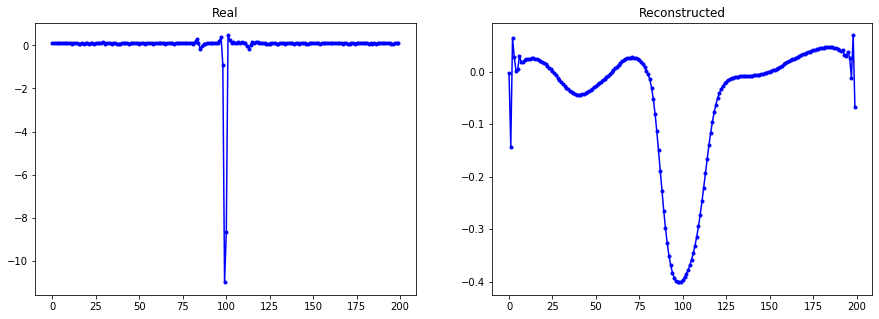

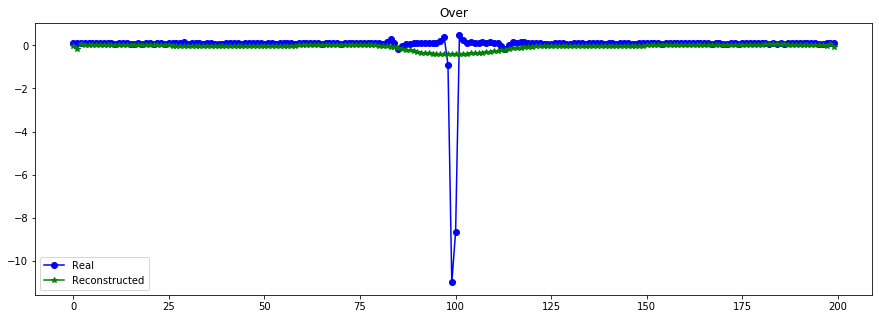

----------------------------------------------------------------


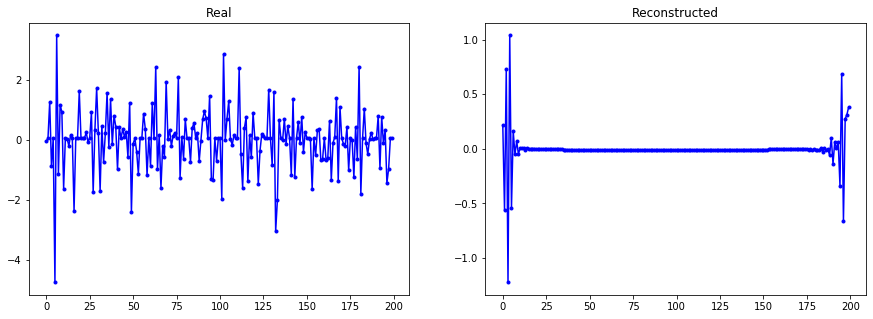

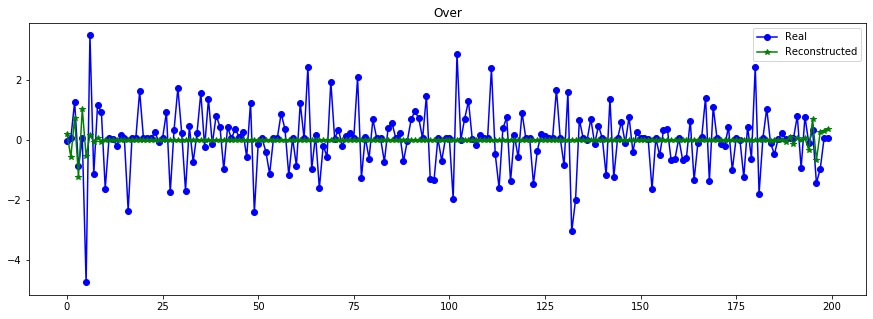

----------------------------------------------------------------


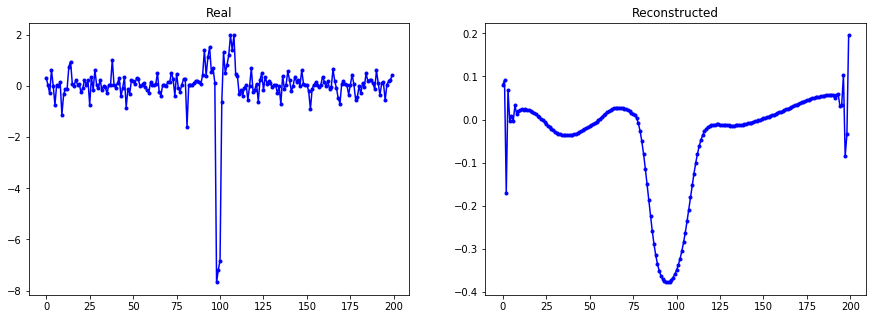

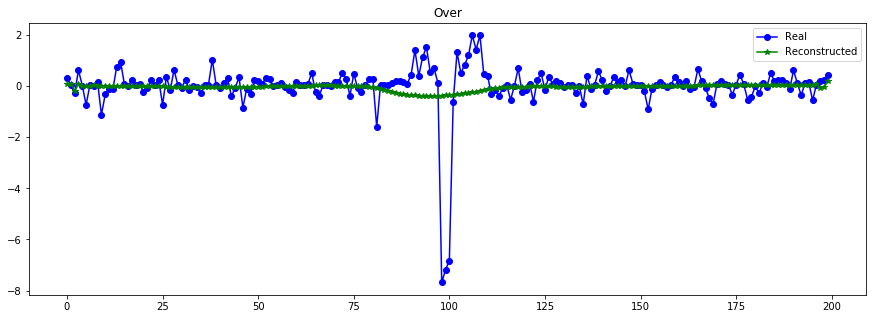

----------------------------------------------------------------


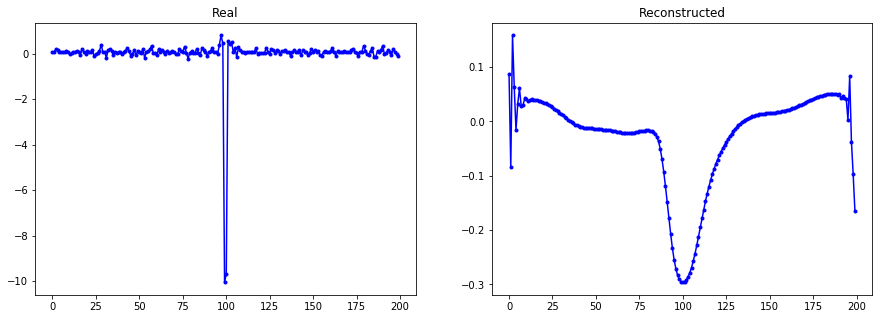

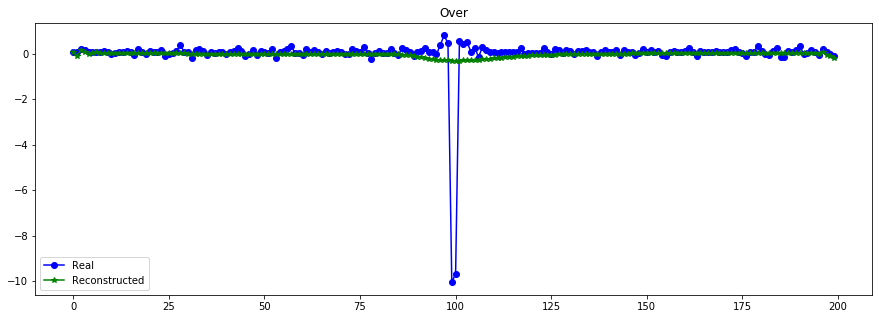

----------------------------------------------------------------


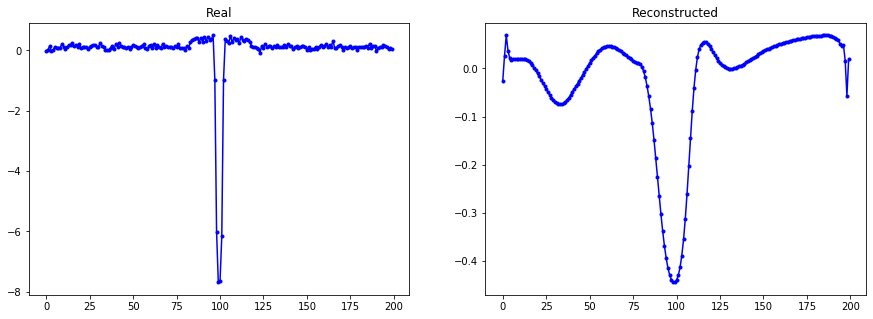

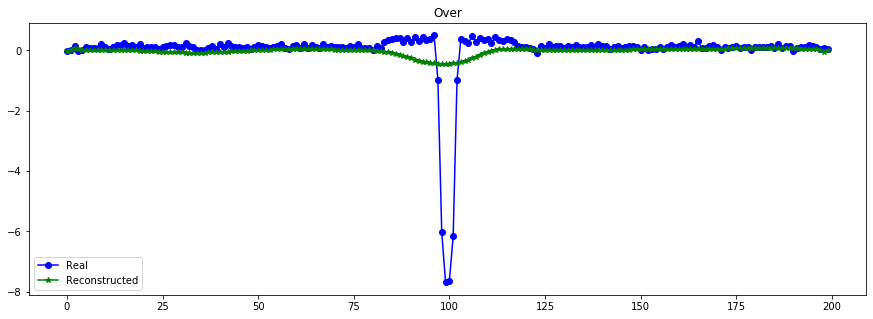

----------------------------------------------------------------


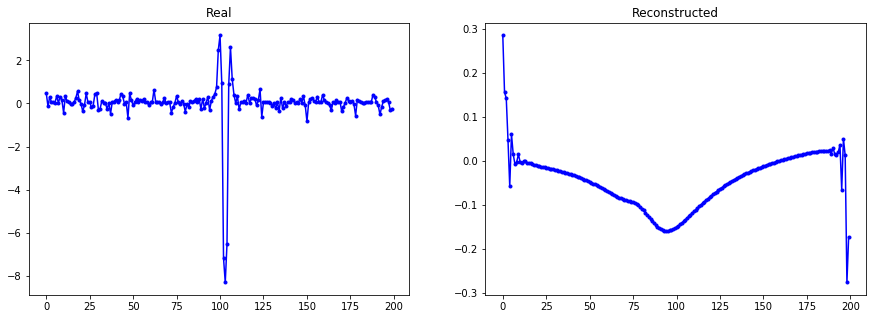

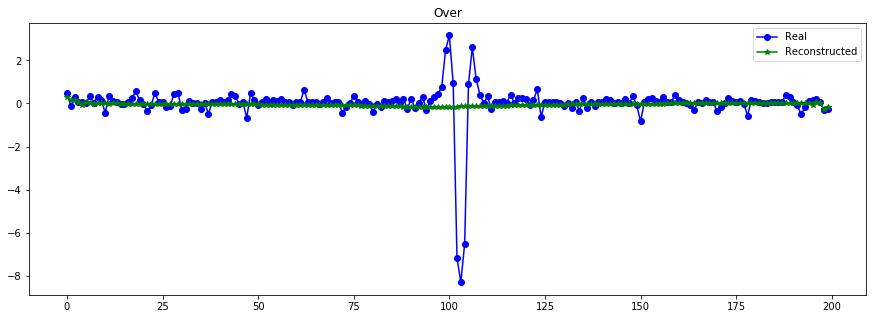

----------------------------------------------------------------


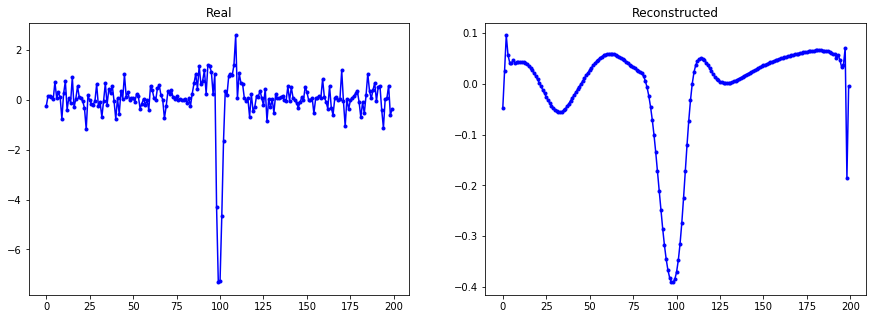

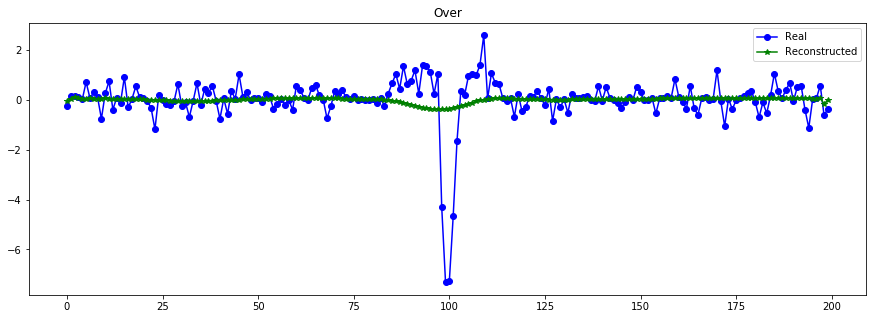

----------------------------------------------------------------


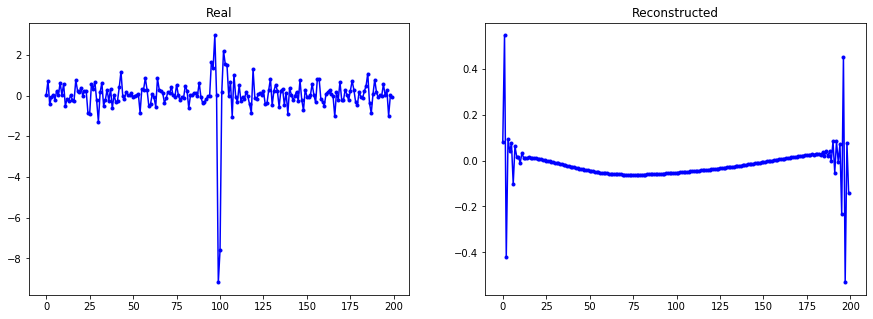

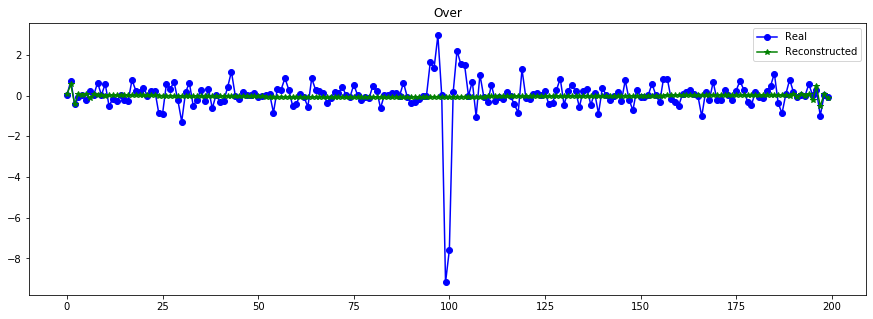

----------------------------------------------------------------


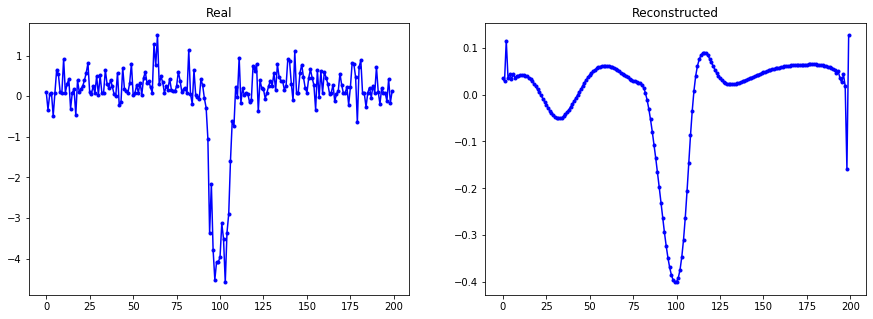

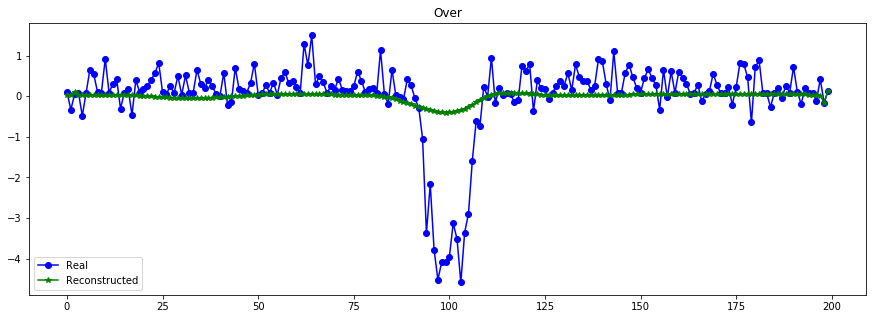

----------------------------------------------------------------


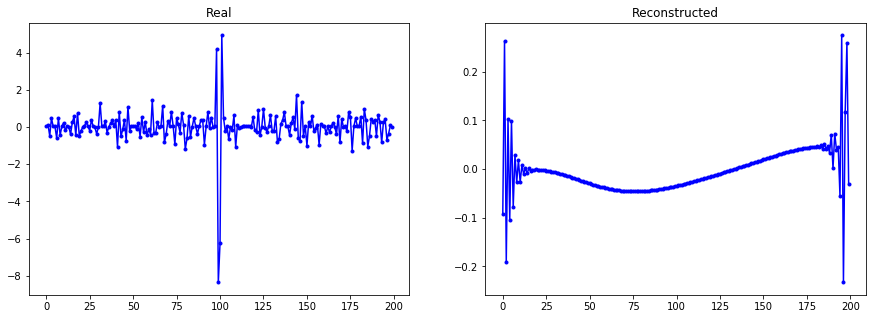

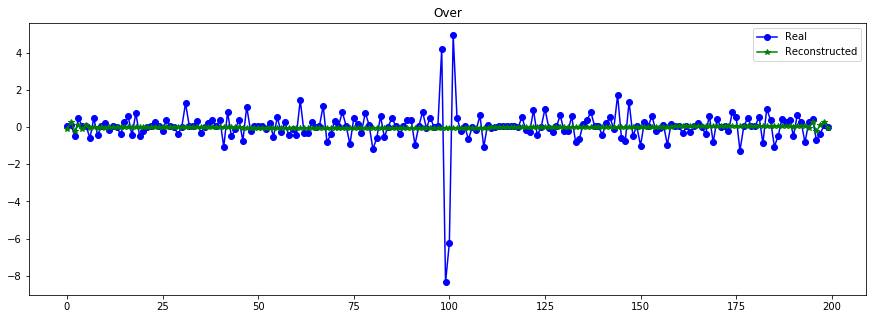

----------------------------------------------------------------


In [22]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

In [ ]:
keras.optimizers.Adam(learning_rate=5e-4) #naul
keras.optimizers.Adam(learning_rate=2e-4) #tsang
notroso 1e-3 == 0.001
#dropa de 0.25
#tsamg baja embedd a 16
#todos con epochs > 100

In [22]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(96, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(96, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(96, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(96, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)
vae.compile(optimizer=keras.optimizers.Adam(lr=5e-4), loss=vae_loss, metrics = [KL_loss, recon_loss])
vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 64)           248192      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       259969      T_inp[0][0]                

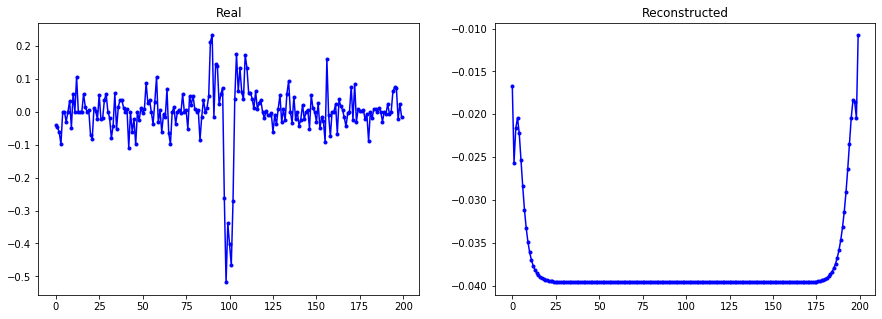

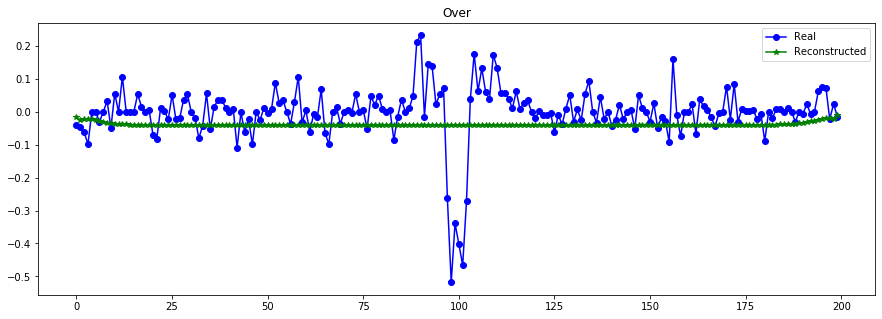

----------------------------------------------------------------


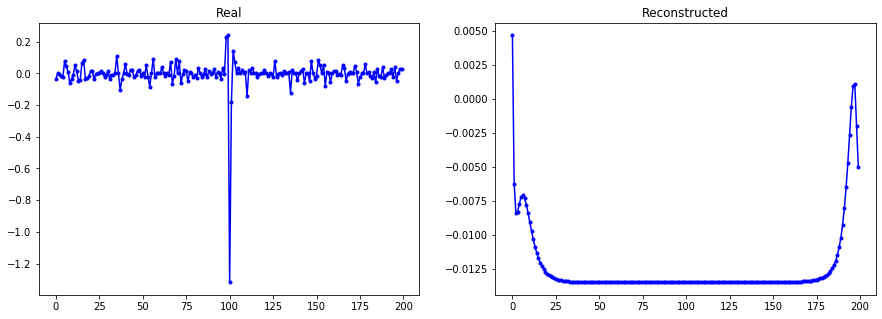

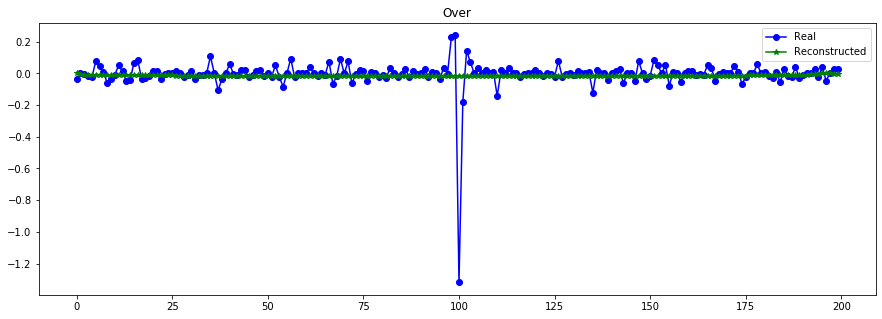

----------------------------------------------------------------


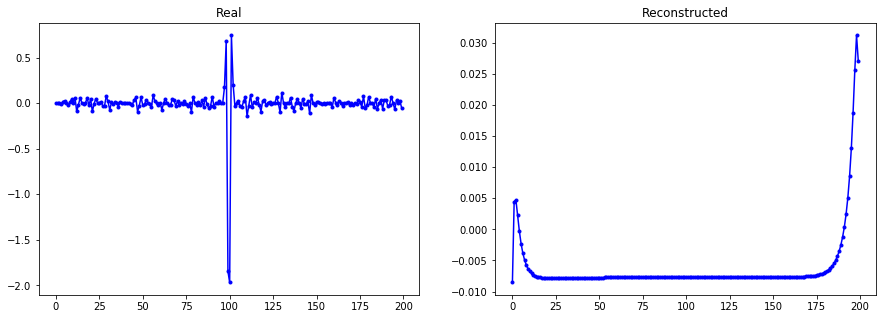

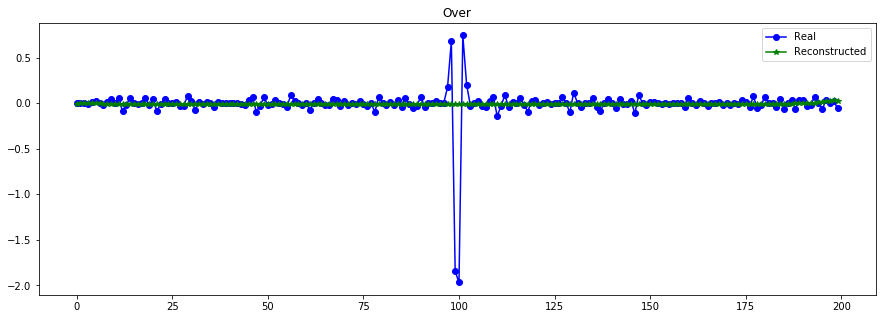

----------------------------------------------------------------


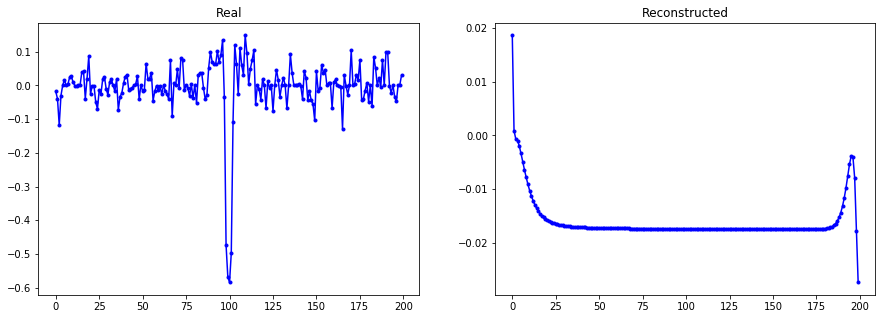

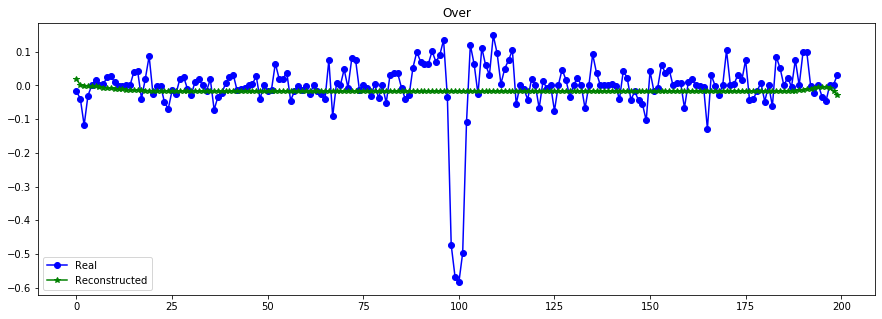

----------------------------------------------------------------


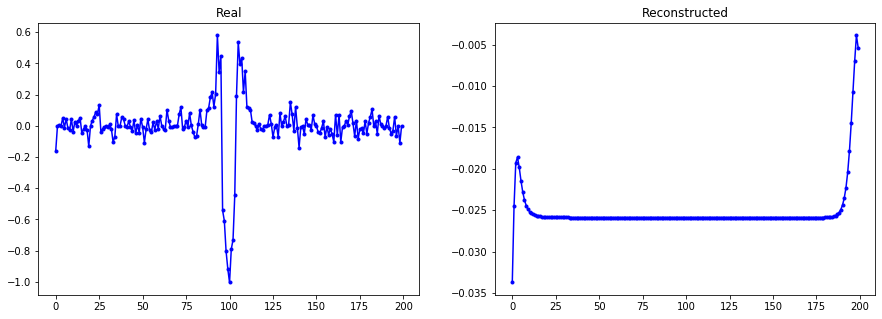

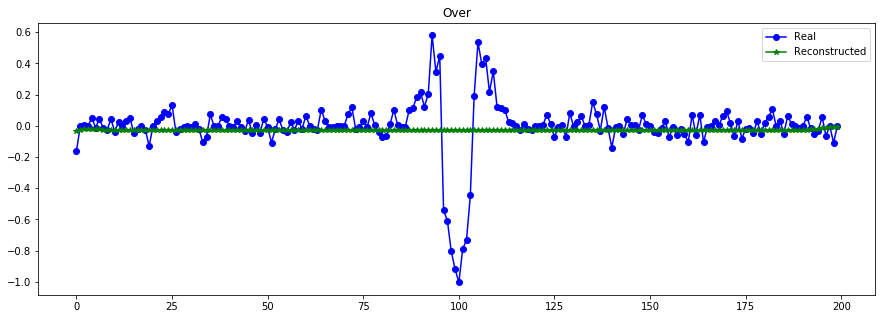

----------------------------------------------------------------


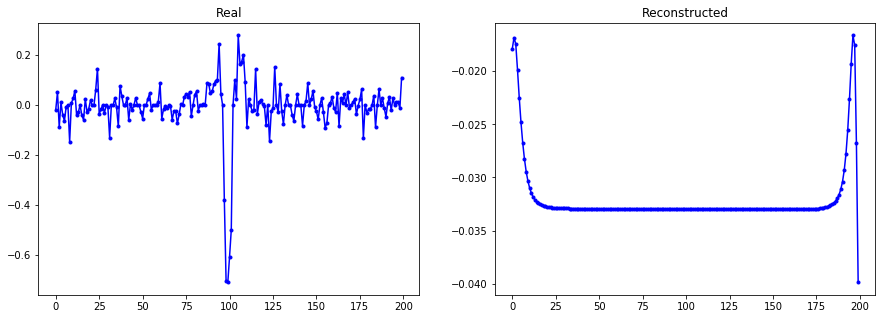

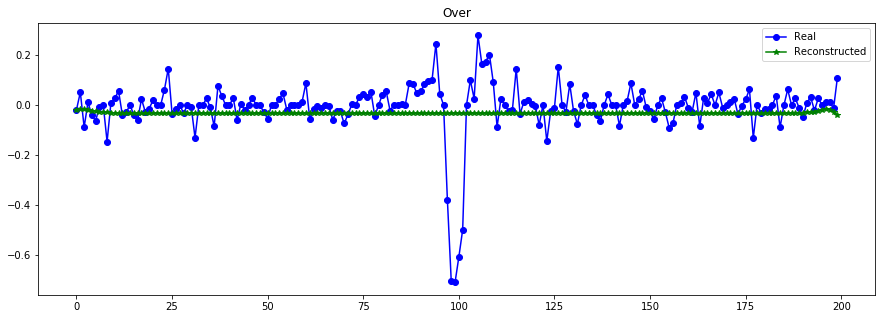

----------------------------------------------------------------


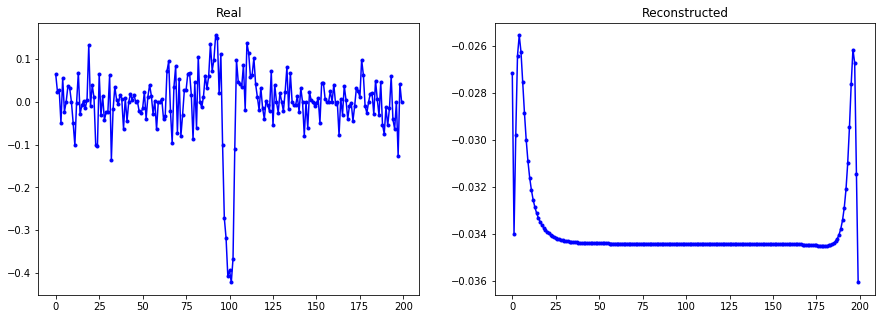

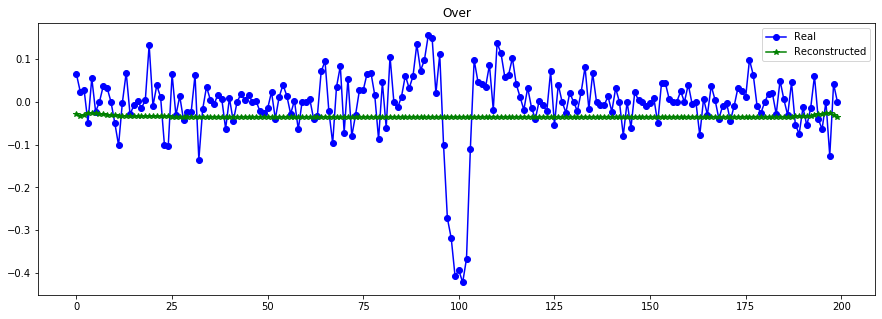

----------------------------------------------------------------


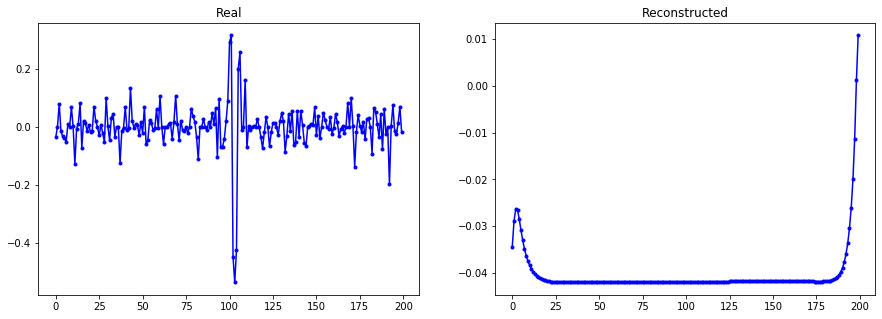

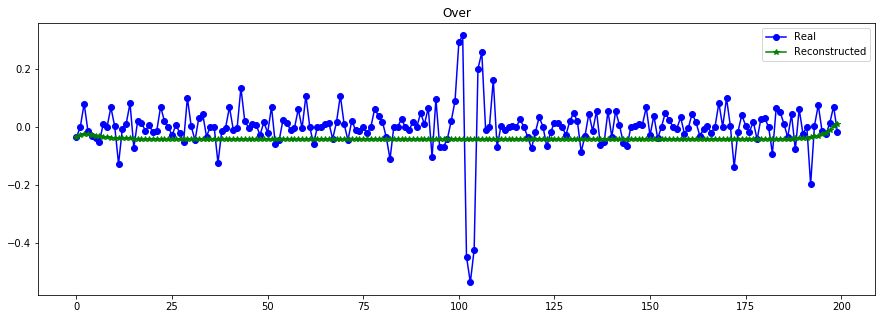

----------------------------------------------------------------


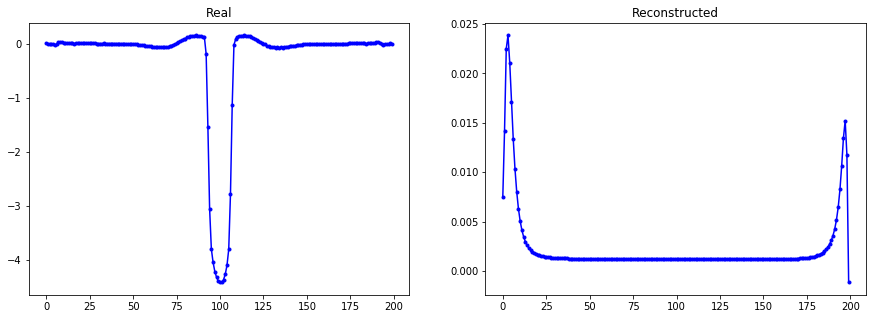

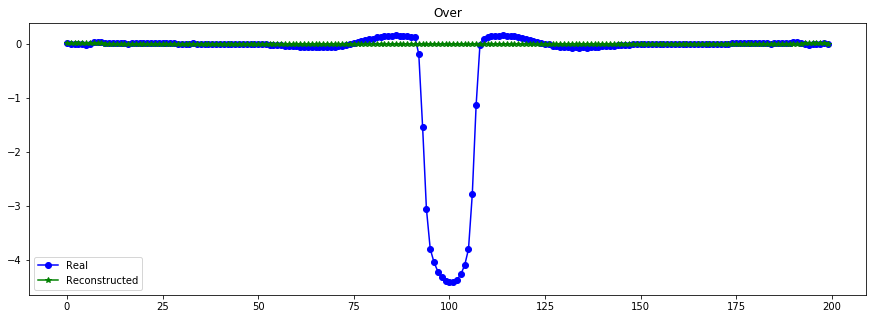

----------------------------------------------------------------


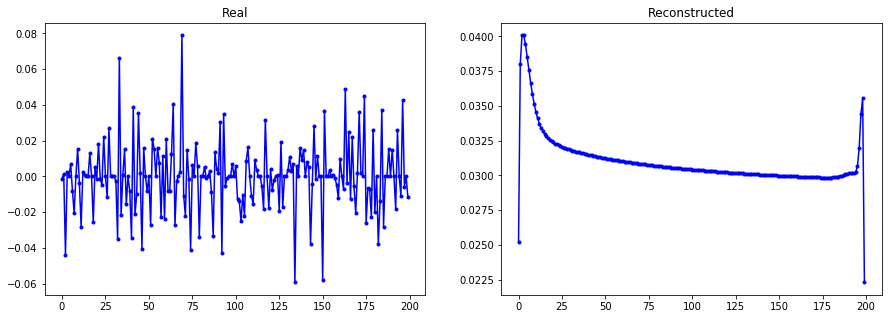

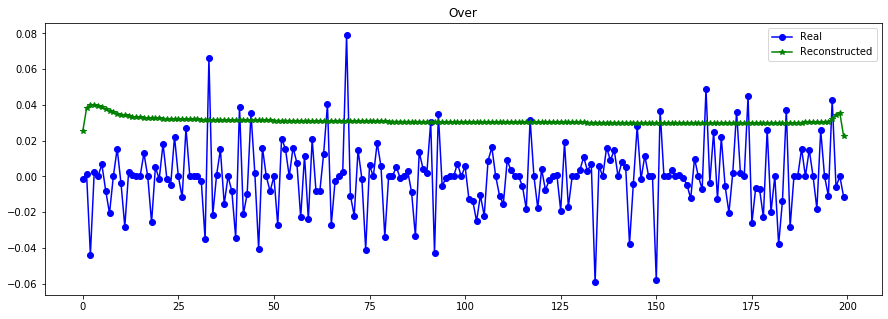

----------------------------------------------------------------


In [23]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

{'whiskers': [<matplotlib.lines.Line2D at 0x2aed7f739a58>,
 'caps': [<matplotlib.lines.Line2D at 0x2aededb51a90>,
 'boxes': [<matplotlib.lines.Line2D at 0x2aededb41f98>],
 'medians': [<matplotlib.lines.Line2D at 0x2aededb51e80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2aededb51f60>],
 'means': []}

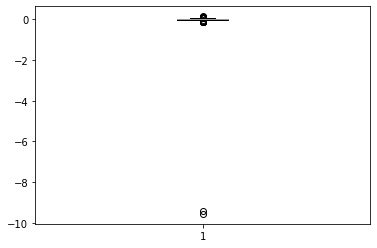

In [24]:
plt.boxplot(X_train[0,:,0])

In [23]:
#https://towardsdatascience.com/deep-quantile-regression-c85481548b5a
#https://arxiv.org/pdf/1808.08798.pdf
def vae_titled_loss(q):
    def loss(y_true, y_pred):
        e = y_true - y_pred #residuals
        return K.flatten(K.sum( K.maximum(q*e, (q-1)*e), axis=1)) + 0.01*KL_loss(y_true,y_pred)
    return loss

In [ ]:
x_lc = Input(shape = (T, channels) , name="LC_inp")
x_t = Input(shape = (T, channels) , name ="T_inp")

x = Concatenate(axis=-1)([x_t, x_lc]) #add time encode

f1 = Bidirectional(GRU(64, return_sequences=True))(x) #bidirectional
f1 = Bidirectional(GRU(64, return_sequences=False))(f1) #bidirectional

z_mean = Dense(latent_dim,activation='linear')(f1)
z_log_var = Dense(latent_dim,activation='linear')(f1)
encoder = Model([x_t, x_lc], z_mean, name="encoder")
z = Lambda(sampling, output_shape=(latent_dim,), name='sample')([z_mean, z_log_var])
samp_encoder = Model([x_t, x_lc], z, name="encoder_sampling")

decoder_input = Input(shape=(latent_dim,))

decode = RepeatVector(T)(decoder_input)

decode = Concatenate(axis=-1)([x_t, decode]) #add time decode

decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional
decode = Bidirectional(GRU(64, return_sequences=True))(decode) #bidirectional

decode = TimeDistributed(Dense(1, activation='linear'))(decode)
generator = Model([x_t, decoder_input], decode, name="generator")

# instantiate VAE model
out = generator([x_t, samp_encoder([x_t, x_lc]) ])
vae = Model([x_t, x_lc], out)

vae.compile(optimizer='adam', loss=vae_titled_loss(0.25), metrics = [KL_loss, MSE_loss])

vae.summary()

batch_size = 64
vae.fit([X_train_t,X_train], X_train, epochs=50, batch_size=batch_size, 
        validation_data=([X_test_t,X_test], X_test))

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
T_inp (InputLayer)              (None, 200, 1)       0                                            
__________________________________________________________________________________________________
LC_inp (InputLayer)             (None, 200, 1)       0                                            
__________________________________________________________________________________________________
encoder_sampling (Model)        (None, 32)           108096      T_inp[0][0]                      
                                                                 LC_inp[0][0]                     
__________________________________________________________________________________________________
generator (Model)               (None, 200, 1)       111873      T_inp[0][0]                

Epoch 36/50
 704/3220 [=====>........................] - ETA: 1:54 - loss: 44.8623 - KL_loss: 14.7747 - MSE_loss: 1.0645

In [ ]:
X_train_hat = vae.predict([X_train_t,X_train], batch_size=512)
plot_n_lc(X_train, X_train_hat, n= 10)

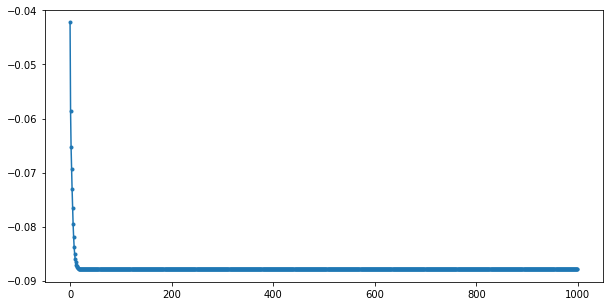

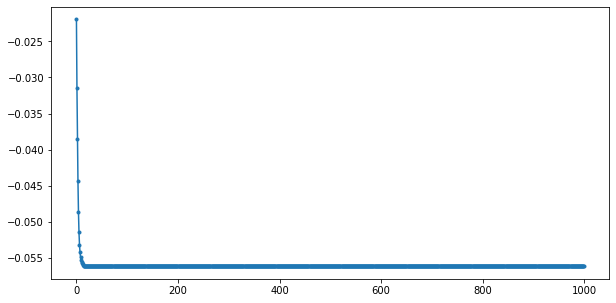

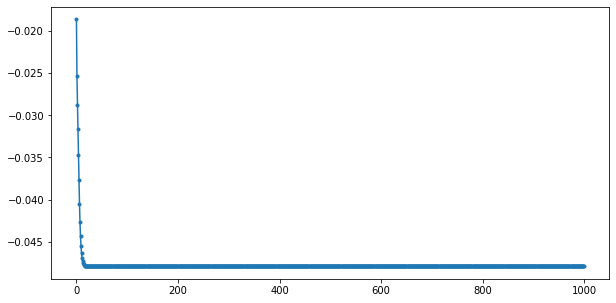

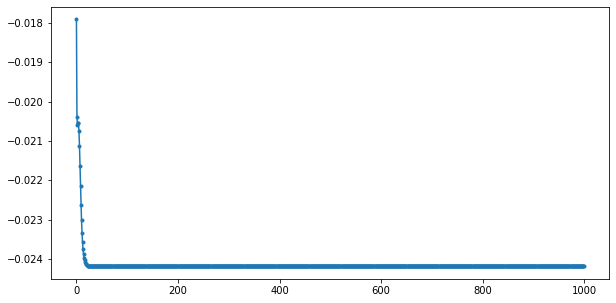

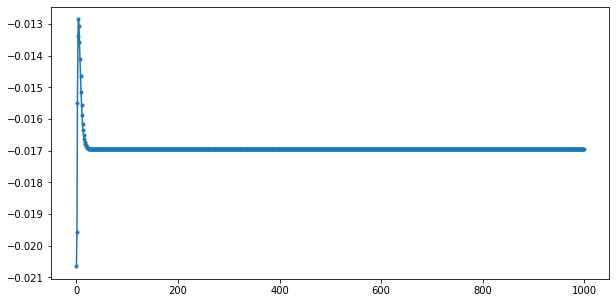

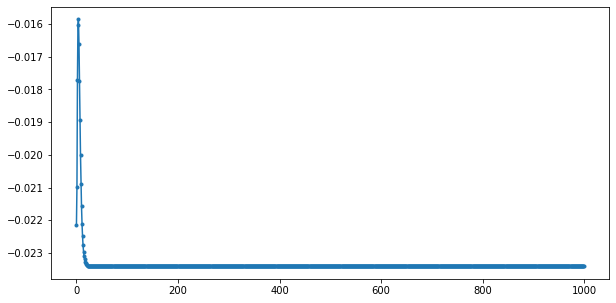

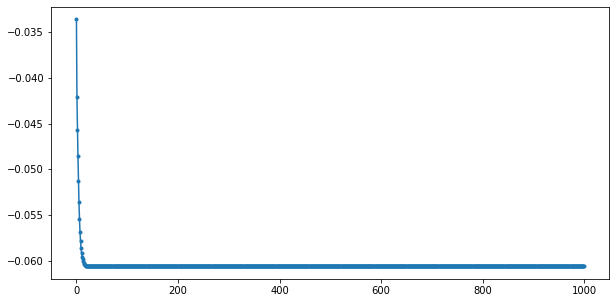

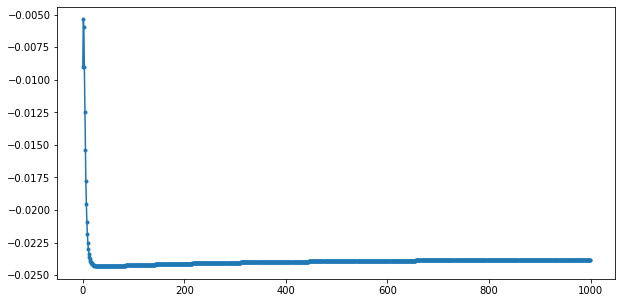

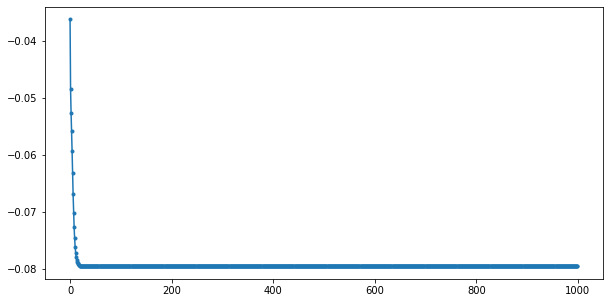

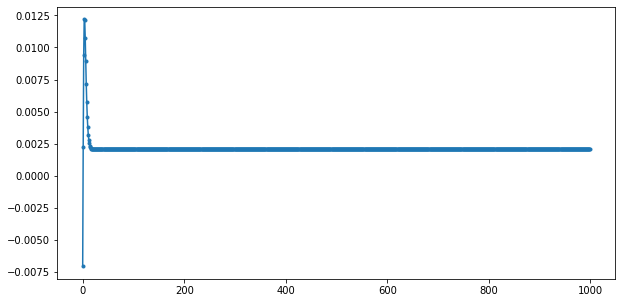

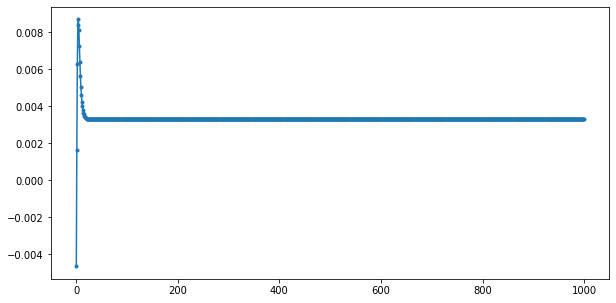

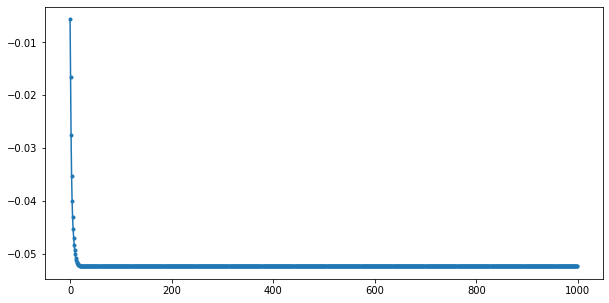

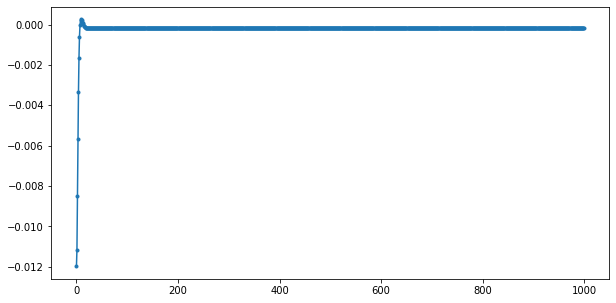

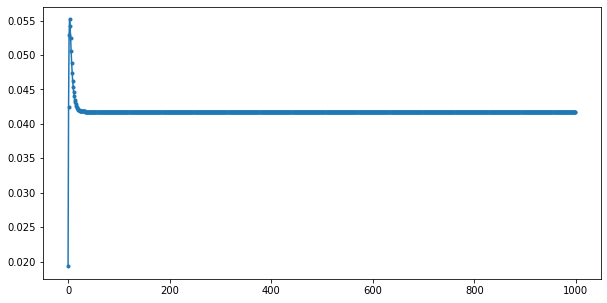

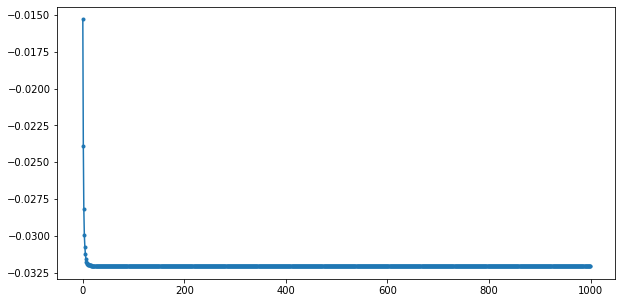

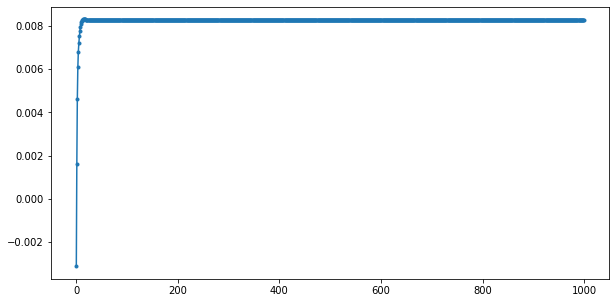

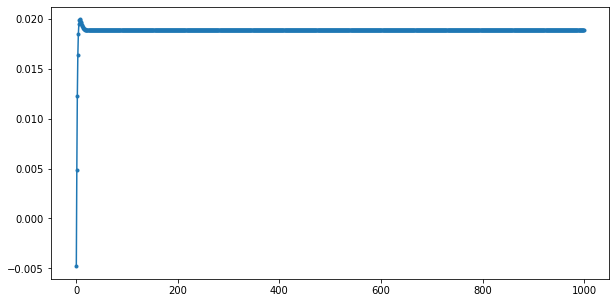

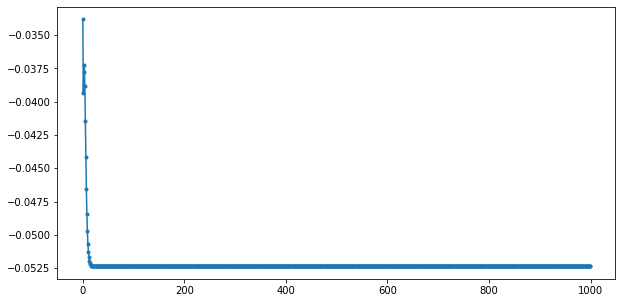

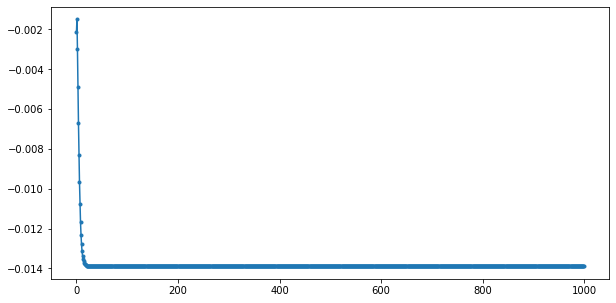

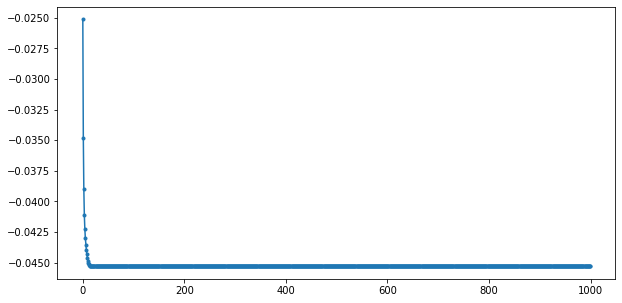

In [140]:
## generate random
n = 20

z_sampleds = np.random.normal(0, 1, size=(n,latent_dim))

x_decoded = generator.predict(z_sampleds)

for i in range(n):
    plt.figure(figsize=(10,5))
    plt.plot(x_decoded[i,:,0], '.-')
    plt.show()

## CONDITIONAL VAE

In [ ]:
cond = Input(input_shape=(D_dim,))


In [ ]:
inputs = merge([X, cond], mode='concat', concat_axis=1) #en el encoder..


In [ ]:
z_cond = merge([z, cond], mode='concat', concat_axis=1) # <--- NEW! #o en el decode (RNN)

In [ ]:
#for generator
d_z = Input(shape=(latent_dim,))
d_cond = Input(shape=(D_dim,))
d_inputs = merge([d_z, d_cond], mode='concat', concat_axis=1)


## Semi-Supervised VAE

In [ ]:
### data augmentation with mandel-agol